# Portfolioprojekt: Depression and anxiety data

The project was given from:

https://www.kaggle.com/datasets/shahzadahmad0402/depression-and-anxiety-data/code


***
We have the following tasks:
* Data reading and cleaning,
* first Feature Engineering,
* Base model, fit the dates to the model,
* Combination to the pipeline,
* Model interpretation.
***

**Szenario:** Man soll anhand einer Datenbak von Depressionsfällen, neuen Depressionsfälle verhersagen.

Dabei wird die csv-Datei eingelesen und unterteilt in Train + Test und Vorhersage Daten bei denen eben die Fälle vorhergesagt weren sollen.



## Preparation

Ein Data-Science-Modell hat immer die Aufgabe, ein bestimmtes Problem zu lösen. Also befasse dich am besten kurz nochmal mit der Aufgabenstellung und überlege dir den Kontext deines Modells.
* Welches Problem soll das Modell lösen?
* Welcher Art ist das Problem (z.B. Klassifikation, Regression, Clustering ...)
* Wie sähe eine Anwendung aus, die dein Modell benutzt?
* Welche Anforderungen stellt der Auftraggeber an dein Modell?
* Welche Daten benötigst du, um dein Modell zu bauen?

### Define Metric

Anhand deines Verständnisses des vorliegenden Problems solltet du dir nun überlegen, welche Metrik(en) am besten geeignet sind, den Erfolg deines Modells zu beurteilen.

In [2]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score

# Überlegung zu den Metriken

# Accuracy: Der Anteil der korrekten Vorhersagen. 
            # In deinem Fall könnte diese Metrik weniger wichtig sein, 
           # ev. habe ich ein unausgewogenes Dataset (mehr gute Käufe als Fehlkäufe).
# Bessere Metriken
# Recall (Sensitivity): Der Anteil der korrekt identifizierten Fehlkäufe an allen 
#                       tatsächlichen Fehlkäufen. Hier optmiere ich: Möglichst viele Fehlkäufe zu erkennen.
# Precision (Genauigkeit): Der Anteil der korrekt identifizierten Fehlkäufe an allen als Fehlkäufe 
#                        vorhergesagten Autos. Wichtig, um falsche Fehlkäufe zu minimieren.
# Am besten die Gewichtung zwischen beiden:
# F1-Score: Der harmonische Mittelwert von Precision und Recall. 
# Hier habe ich ein Gleichgewicht zwischen Precision und Recall zu finden.

### Gather Data

We have the dataset: *depression_anxiety_data.csv*. With the target-column: 'depressiveness

In [3]:
# import modules 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Modelle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Pipeline
from sklearn.pipeline import Pipeline
# Columntransormer
from sklearn.compose import ColumnTransformer
# OneHotEndode,, Scaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Train/Test Splitt, Crossvaue-Score, SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

In [4]:
# read data
df = pd.read_csv("depression_anxiety_data.csv")

display(df.head())
#print(df)

,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,depressiveness,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness
0,1,1,19,male,33.333333,Class I Obesity,9,Mild,False,False,False,False,11,Moderate,True,False,False,7.0,False
1,2,1,18,male,19.841270,Normal,8,Mild,False,False,False,False,5,Mild,False,False,False,14.0,True
2,3,1,19,male,25.102391,Overweight,8,Mild,False,False,False,False,6,Mild,False,False,False,6.0,False
3,4,1,18,female,23.738662,Normal,19,Moderately severe,True,True,False,False,15,Severe,True,False,False,11.0,True
4,5,1,18,male,25.617284,Overweight,6,Mild,False,False,False,False,14,Moderate,True,False,False,3.0,False


## EDA

### Understand Data

Mach dich zu Beginn mit den Daten vertraut, damit du später bei der Datenbereinigung und -aufbereitung weißt, worauf du achten solltest.

**Tipp**: Die Spalte `'PurchDate'` ist als Unix-Timestamp in ganzen Sekunden angegeben. Um diese Spalte mit `pandas` in ein Datumsformat umzuwandeln, kannst du folgenden Code nutzen: `my_df.loc[:, 'PurchDate'] = pd.to_datetime(my_df.loc[:, 'PurchDate'], unit='s')`

In [5]:


# 2. Datentypen überprüfen
print("\nDatentypen der Spalten:")
display(df.dtypes)

# 3. Statistische Zusammenfassung





Datentypen der Spalten:


id                        int64
school_year               int64
age                       int64
gender                   object
bmi                     float64
who_bmi                  object
phq_score                 int64
depression_severity      object
depressiveness           object
suicidal                 object
depression_diagnosis     object
depression_treatment     object
gad_score                 int64
anxiety_severity         object
anxiousness              object
anxiety_diagnosis        object
anxiety_treatment        object
epworth_score           float64
sleepiness               object
dtype: object

In [7]:
#check NaNs and duplicates
print('Index')
print('index_size', df.index.size)
print('Columns with NaN')
print('is NaN', df.isna().sum())
print('Duplicates in Columns')
print('duplicated', df.duplicated().sum())
#note: no NaNs, no duplicates, no cleaning required

Index
index_size 783
Columns with NaN
is NaN id                      0
school_year             0
age                     0
gender                  0
bmi                     0
who_bmi                 0
phq_score               0
depression_severity     4
depressiveness          3
suicidal                1
depression_diagnosis    1
depression_treatment    4
gad_score               0
anxiety_severity        0
anxiousness             6
anxiety_diagnosis       4
anxiety_treatment       2
epworth_score           8
sleepiness              8
dtype: int64
Duplicates in Columns
duplicated 0


In [10]:
# Anzeigen der Duplikate
duplicates = df[df.duplicated()]
print("Duplikate anzeigen:")
print(duplicates)

# Entfernen der Duplikate und Speichern in df_clean
df_clean = df.drop_duplicates()

# Überprüfen der Größe nach dem Entfernen der Duplikate
print("Größe des DataFrames nach dem Entfernen der Duplikate:")
print('Index size', df_clean.index.size)

# Optional: Überprüfen, ob es noch Duplikate gibt
print("Überprüfung, ob noch Duplikate vorhanden sind:")
print('duplicated', df_clean.duplicated().sum())


Duplikate anzeigen:
Empty DataFrame
Columns: [id, school_year, age, gender, bmi, who_bmi, phq_score, depression_severity, depressiveness, suicidal, depression_diagnosis, depression_treatment, gad_score, anxiety_severity, anxiousness, anxiety_diagnosis, anxiety_treatment, epworth_score, sleepiness]
Index: []
Größe des DataFrames nach dem Entfernen der Duplikate:
Index size 783
Überprüfung, ob noch Duplikate vorhanden sind:
duplicated 0


In [11]:
# Liste der interessierenden Spalten
columns_of_interest = [
    'gender', 'who_bmi', 'depression_severity', 'depressiveness', 'suicidal', 
    'depression_diagnosis', 'depression_treatment', 'anxiety_severity', 
    'anxiousness', 'anxiety_diagnosis', 'anxiety_treatment', 'epworth_score', 
    'sleepiness'
]

# Durch jede Spalte iterieren und die eindeutigen Werte anzeigen
for column in columns_of_interest:
    unique_values = df[column].unique()
    print(f"Einzigartige Werte in der Spalte '{column}':")
    print(unique_values)
    print()




Einzigartige Werte in der Spalte 'gender':
['male' 'female']

Einzigartige Werte in der Spalte 'who_bmi':
['Class I Obesity' 'Normal' 'Overweight' 'Not Availble'
 'Class III Obesity' 'Underweight' 'Class II Obesity']

Einzigartige Werte in der Spalte 'depression_severity':
['Mild' 'Moderately severe' 'None-minimal' 'Moderate' nan 'Severe' 'none']

Einzigartige Werte in der Spalte 'depressiveness':
[False True nan]

Einzigartige Werte in der Spalte 'suicidal':
[False True nan]

Einzigartige Werte in der Spalte 'depression_diagnosis':
[False True nan]

Einzigartige Werte in der Spalte 'depression_treatment':
[False True nan]

Einzigartige Werte in der Spalte 'anxiety_severity':
['Moderate' 'Mild' 'Severe' 'None-minimal' '0']

Einzigartige Werte in der Spalte 'anxiousness':
[True False nan]

Einzigartige Werte in der Spalte 'anxiety_diagnosis':
[False True nan]

Einzigartige Werte in der Spalte 'anxiety_treatment':
[False True nan]

Einzigartige Werte in der Spalte 'epworth_score':
[ 7. 1

In [12]:
# Clean the Datatypes:


# 1.) Target skip the NaN
# Trainingszweck!!!

# df = df.dropna(subset=['depressiveness'])

# all to string if I have NaN in the object

# 2.) Convert the boolean to string:

## Drop !!! ev. besser!!!
#columns_to_convert = ['suicidal', 'depression_diagnosis', 'depression_treatment', 'anxiousness', 'anxiety_diagnosis']
#df[columns_to_convert] = df[columns_to_convert].astype(str)

# Einfacher: Entferne alle NaNs
df = df.dropna()


# Setzen der Target Variablen auf numerische Werte:
df['depressiveness'] = df['depressiveness'].astype(int)
display(df.head())


,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,depressiveness,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness
0,1,1,19,male,33.333333,Class I Obesity,9,Mild,0,False,False,False,11,Moderate,True,False,False,7.0,False
1,2,1,18,male,19.841270,Normal,8,Mild,0,False,False,False,5,Mild,False,False,False,14.0,True
2,3,1,19,male,25.102391,Overweight,8,Mild,0,False,False,False,6,Mild,False,False,False,6.0,False
3,4,1,18,female,23.738662,Normal,19,Moderately severe,1,True,False,False,15,Severe,True,False,False,11.0,True
4,5,1,18,male,25.617284,Overweight,6,Mild,0,False,False,False,14,Moderate,True,False,False,3.0,False


In [13]:

# Durch jede Spalte iterieren und die Verteilung der Werte anzeigen
for column in columns_of_interest:
    value_counts = df[column].value_counts()
    print(f"Verteilung der Werte in der Spalte '{column}':")
    print(value_counts)
    print()

Verteilung der Werte in der Spalte 'gender':
gender
female    394
male      371
Name: count, dtype: int64

Verteilung der Werte in der Spalte 'who_bmi':
who_bmi
Normal               497
Overweight           189
Underweight           35
Class I Obesity       27
Not Availble           8
Class II Obesity       5
Class III Obesity      4
Name: count, dtype: int64

Verteilung der Werte in der Spalte 'depression_severity':
depression_severity
Mild                 339
None-minimal         221
Moderate             136
Moderately severe     42
none                  15
Severe                12
Name: count, dtype: int64

Verteilung der Werte in der Spalte 'depressiveness':
depressiveness
0    560
1    205
Name: count, dtype: int64

Verteilung der Werte in der Spalte 'suicidal':
suicidal
False    700
True      65
Name: count, dtype: int64

Verteilung der Werte in der Spalte 'depression_diagnosis':
depression_diagnosis
False    699
True      66
Name: count, dtype: int64

Verteilung der Werte in der

In [14]:
# Clean the data and correctionof the types

print("\nDatentypen der Spalten:")
display(df.dtypes)

  


Datentypen der Spalten:


id                        int64
school_year               int64
age                       int64
gender                   object
bmi                     float64
who_bmi                  object
phq_score                 int64
depression_severity      object
depressiveness            int32
suicidal                 object
depression_diagnosis     object
depression_treatment     object
gad_score                 int64
anxiety_severity         object
anxiousness              object
anxiety_diagnosis        object
anxiety_treatment        object
epworth_score           float64
sleepiness               object
dtype: object

In [15]:
# check distribution of values in each feature
# Lösung:
display(df.describe())
# display(sns.pairplot(df))  # needs time

,id,school_year,age,bmi,phq_score,depressiveness,gad_score,epworth_score
count,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000,765.000000
mean,394.487582,2.288889,20.257516,23.410511,7.167320,0.267974,6.882353,6.396078
std,226.055561,1.167377,1.772488,4.590204,4.420411,0.443194,4.730071,3.998198
min,1.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,199.000000,1.000000,19.000000,20.957274,4.000000,0.000000,3.000000,4.000000
50%,395.000000,2.000000,20.000000,23.148148,6.000000,0.000000,6.000000,6.000000
75%,591.000000,3.000000,21.000000,25.510204,9.000000,1.000000,9.000000,9.000000
max,783.000000,4.000000,31.000000,54.552668,24.000000,1.000000,21.000000,32.000000



Verteilung der Einträge in der Spalte 'IsBadBuy':
0    57516
1     8104
Name: IsBadBuy, dtype: int64


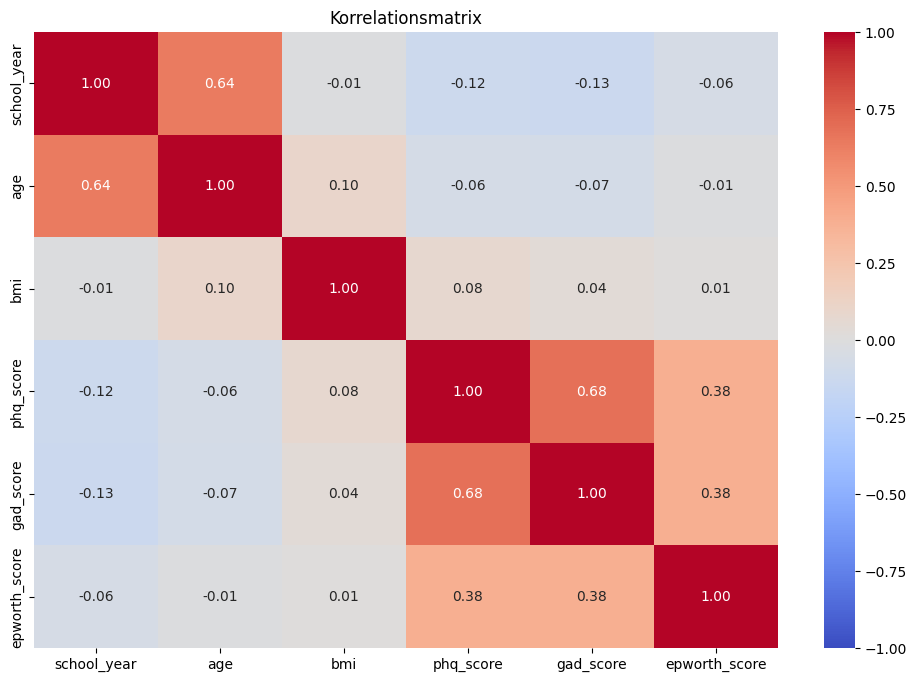

In [16]:
import seaborn as sns

# Auswahl der relevanten Spalten
selected_columns = ['school_year','age','bmi', 'phq_score', 'gad_score', 'epworth_score']

# Korrelationsmatrix der ausgewählten Spalten
corr_matrix = df[selected_columns].corr()


# Heatmap der Korrelationsmatrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin = -1, vmax = 1, fmt='.2f')
plt.title('Korrelationsmatrix')
plt.show()


In [15]:
# Erstes Feature-Engineering


# go on!

# KNN Imputer!!!



In [14]:
# Weiteres Feature (Feature-Engineering):

# Erstellen der neuen Spalte 'Gewinn-Rate':
# Idee: Anschaffungspreis des Autos könnte der mögliche Verkaufspreis später sein,
# Anschaffungskosten sind die Ausgaben, wie teuer ich das Auto erstanden habe, bzw. was
# es kostete damit ich es dann verkaufen kann.
# Dann habe ich Gewinn-Verlust/Gewinn gerechnet, was dann meine Gewinnrate ist



In [16]:
# Weiteres Feature (Feature-Engineering):

# Erstellen der neuen Spalte 'VehicleAge/VehOdo'


In [17]:



num_cols =['school_year','age','bmi', 'phq_score', 'gad_score', 'epworth_score']


cat_cols_full = ['gender', 'who_bmi', 'depression_severity', 
                 'suicidal','depression_diagnosis', 'depression_treatment', 
                 'anxiety_severity','anxiousness', 'anxiety_diagnosis', 'anxiety_treatment', 'sleepiness']

cat_cols = ['gender', 'who_bmi', 'depression_severity', 
                 'suicidal','depression_diagnosis', 'depression_treatment', 
                 'anxiety_severity','anxiousness', 'anxiety_diagnosis', 'anxiety_treatment', 'sleepiness']



target = ['depressiveness']

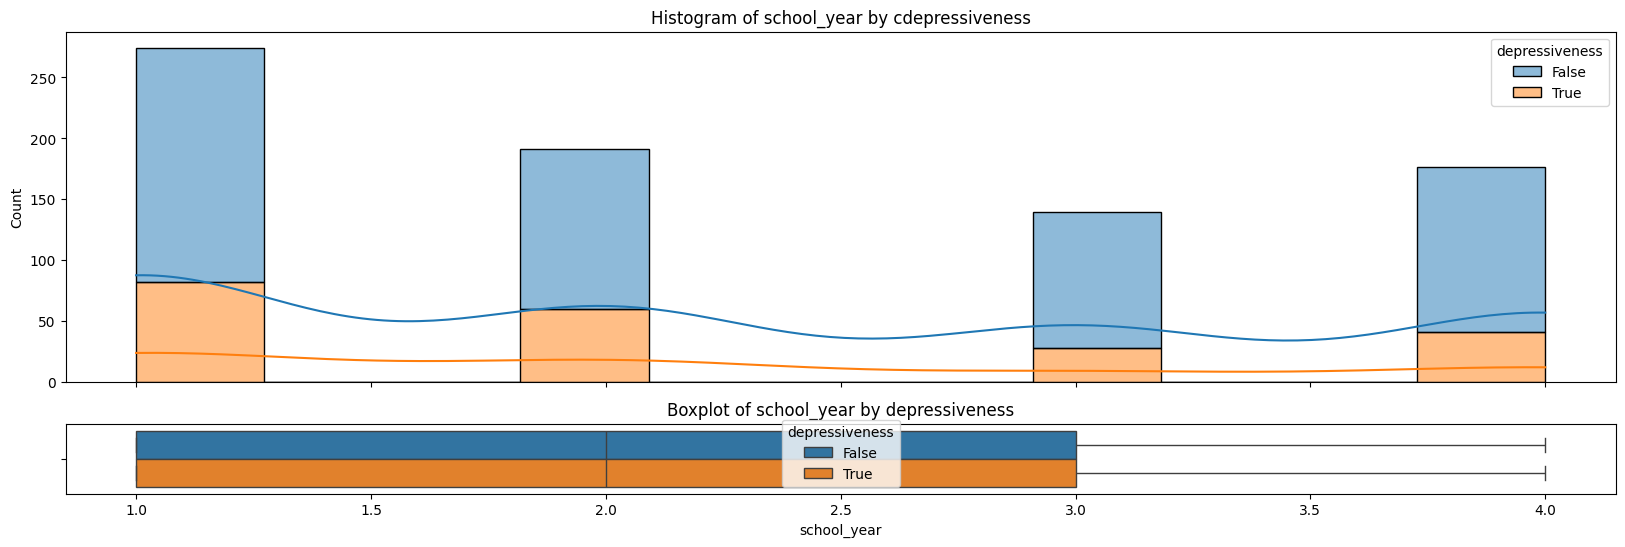

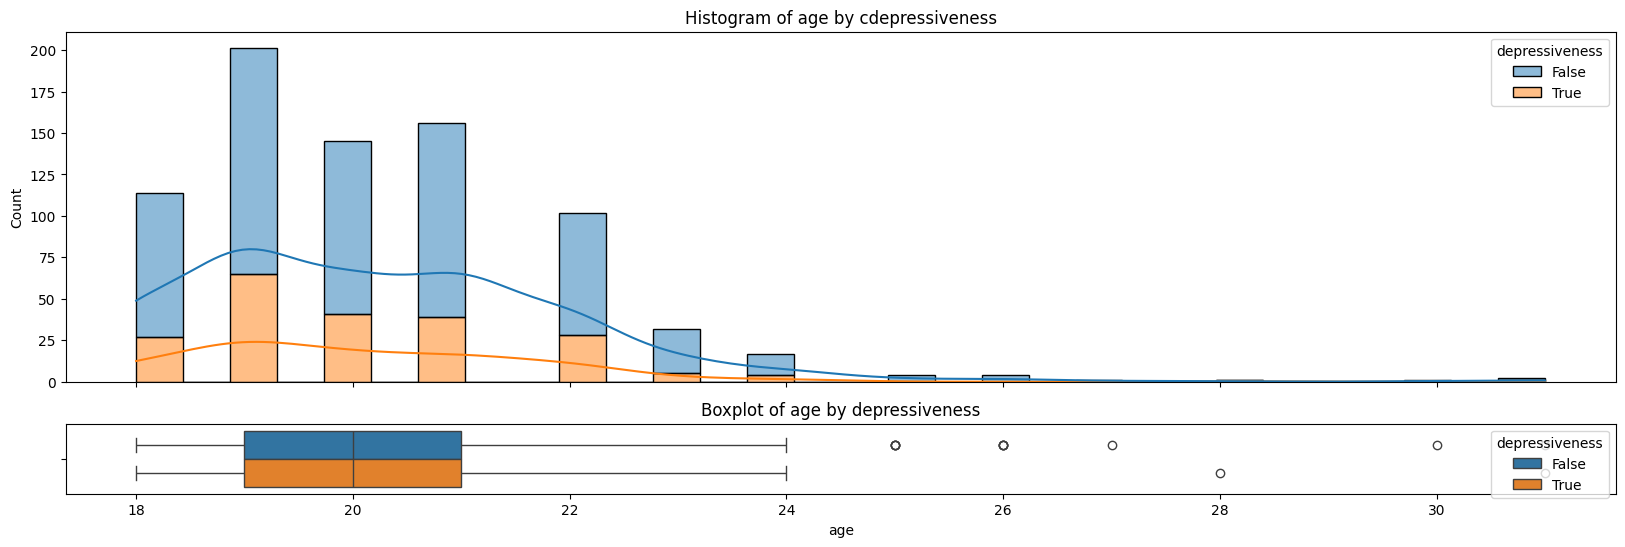

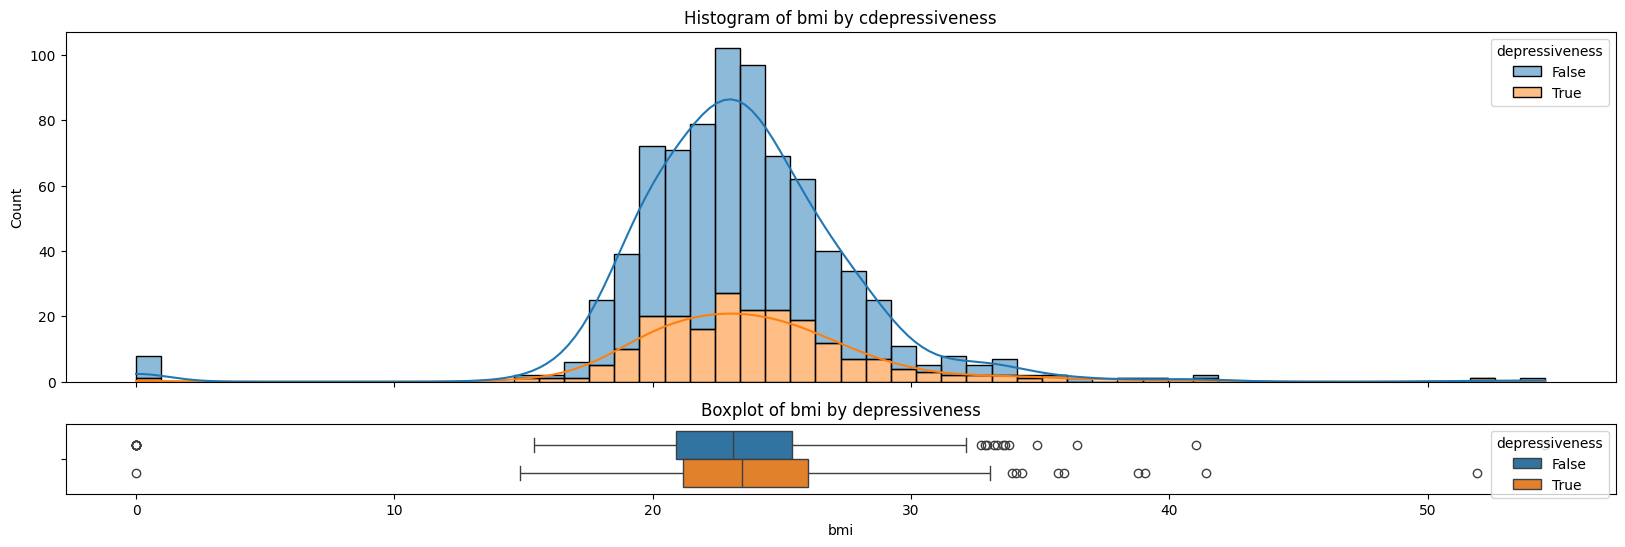

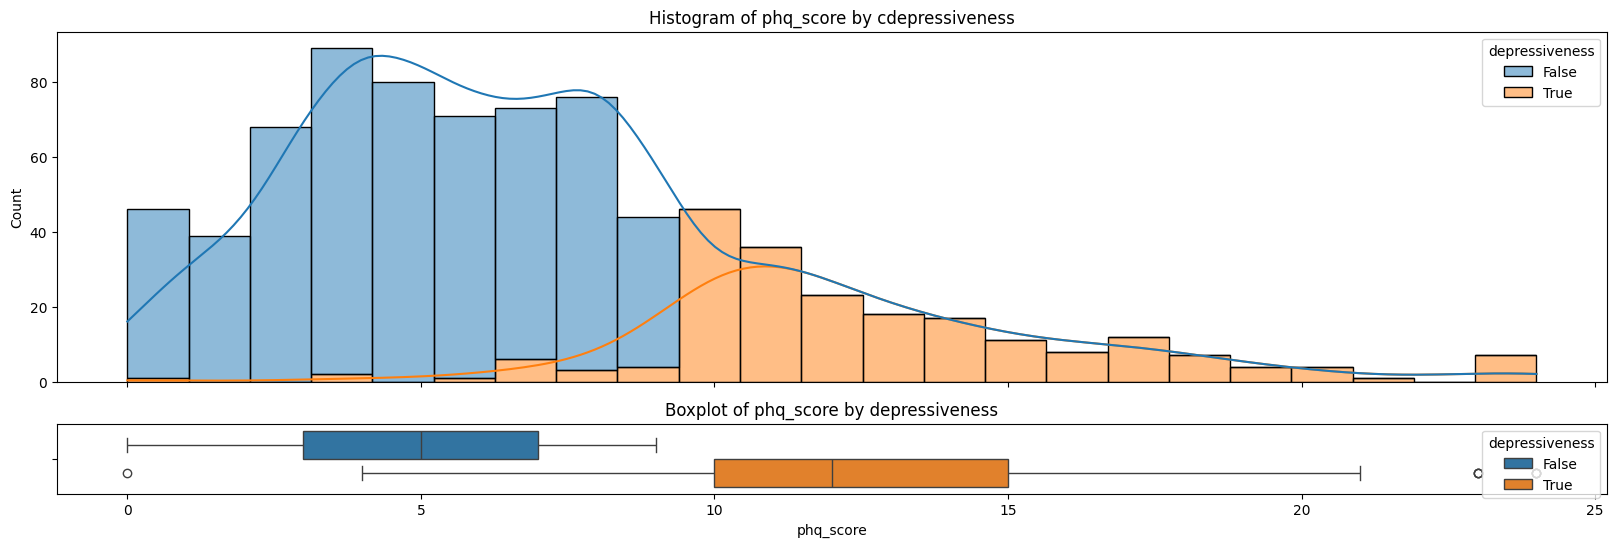

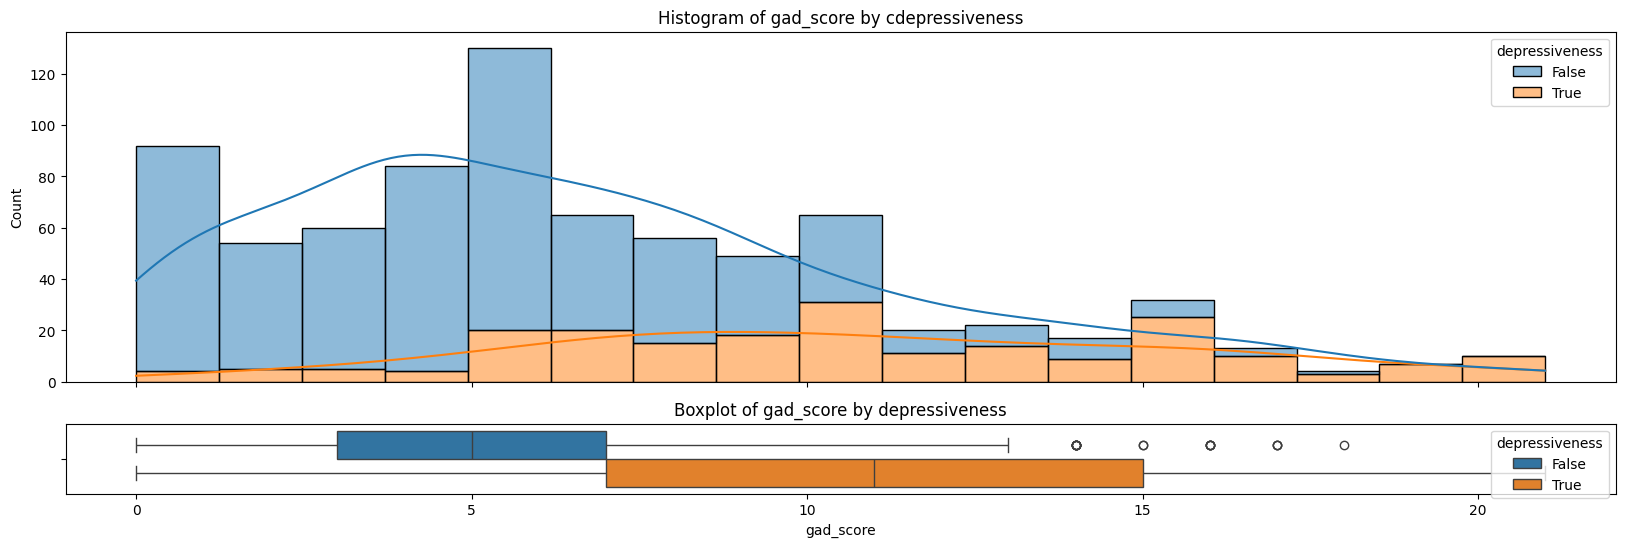

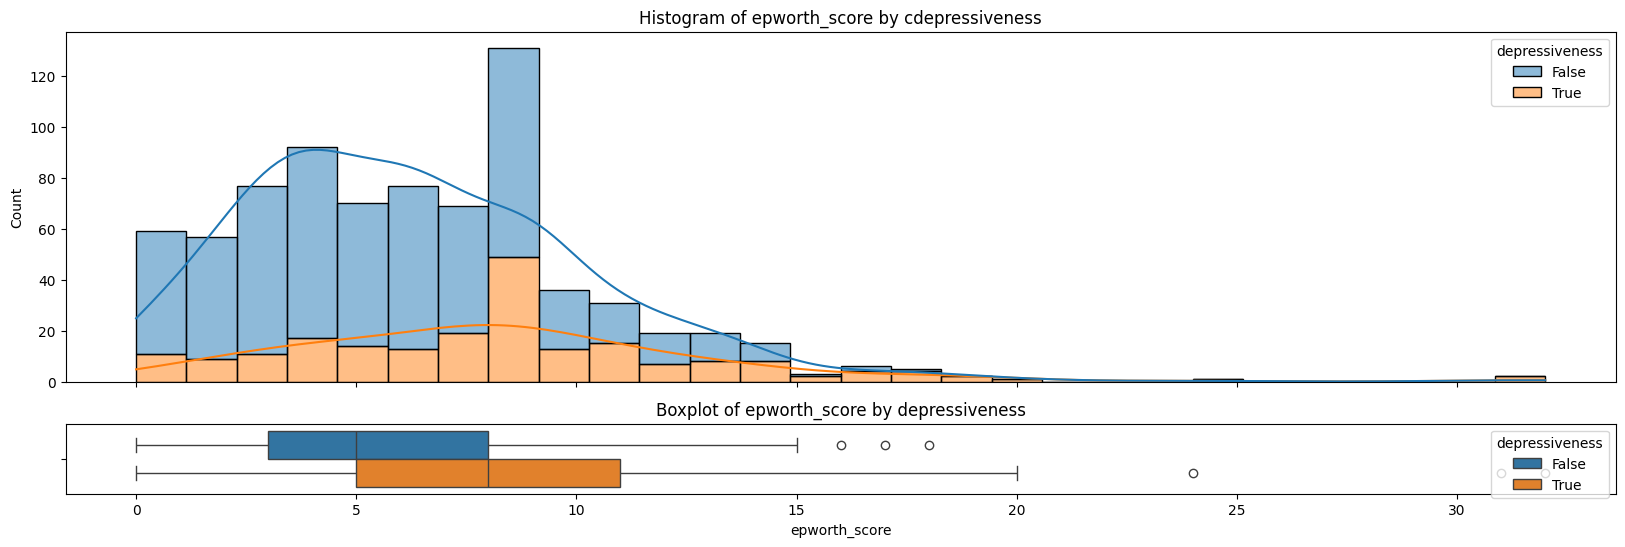

In [100]:

# Histogramme und Boxplots für numerische Spalten mit IsBadBuy als Hue
for col in num_cols:


    # Gesamtplot für Histogramm und kombinierten Boxplot
    fig, axes = plt.subplots(2, 1, figsize=(20, 6), sharex=True, gridspec_kw={'height_ratios': [5, 1]})
    
    # Histogramm
    sns.histplot(data=df_clean, x=col, hue='depressiveness', kde=True, multiple="stack", ax=axes[0])
    axes[0].set_title(f'Histogram of {col} by cdepressiveness')
    
    # Boxplot
    sns.boxplot(data=df_clean, x=col, hue='depressiveness', ax=axes[1])
    axes[1].set_title(f'Boxplot of {col} by depressiveness')



    # Achsenbeschriftungen setzen und Plot zeigen
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('')
    plt.show()
    
        

In [101]:
display(df.head())

,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,depressiveness,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness
0,1,1,19,male,33.333333,Class I Obesity,9,Mild,False,False,False,False,11,Moderate,True,False,False,7.0,False
1,2,1,18,male,19.841270,Normal,8,Mild,False,False,False,False,5,Mild,False,False,False,14.0,True
2,3,1,19,male,25.102391,Overweight,8,Mild,False,False,False,False,6,Mild,False,False,False,6.0,False
3,4,1,18,female,23.738662,Normal,19,Moderately severe,True,True,False,False,15,Severe,True,False,False,11.0,True
4,5,1,18,male,25.617284,Overweight,6,Mild,False,False,False,False,14,Moderate,True,False,False,3.0,False


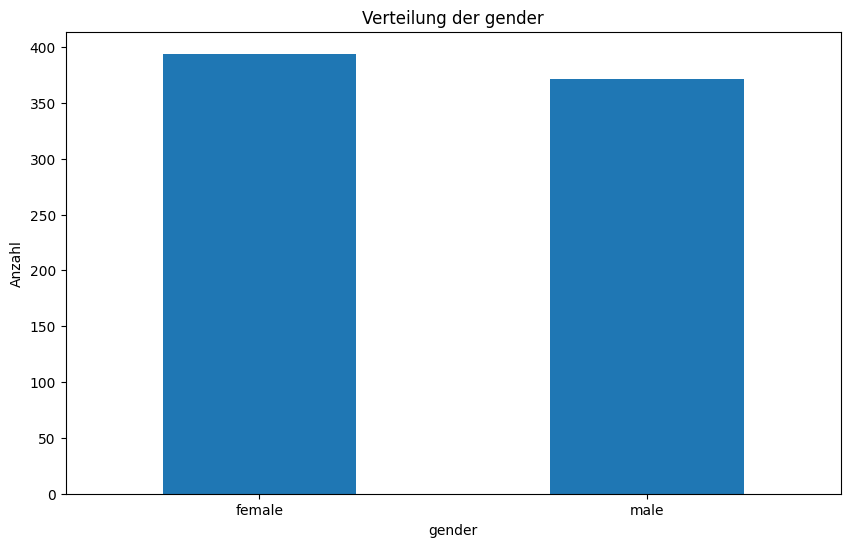

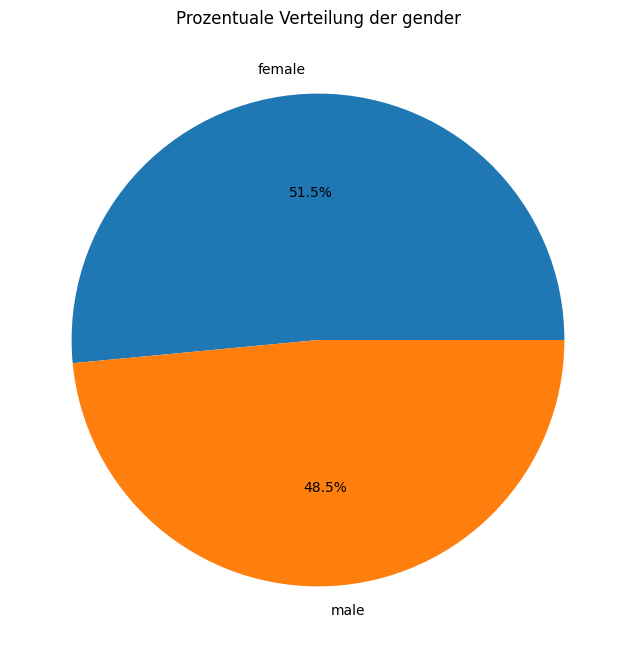

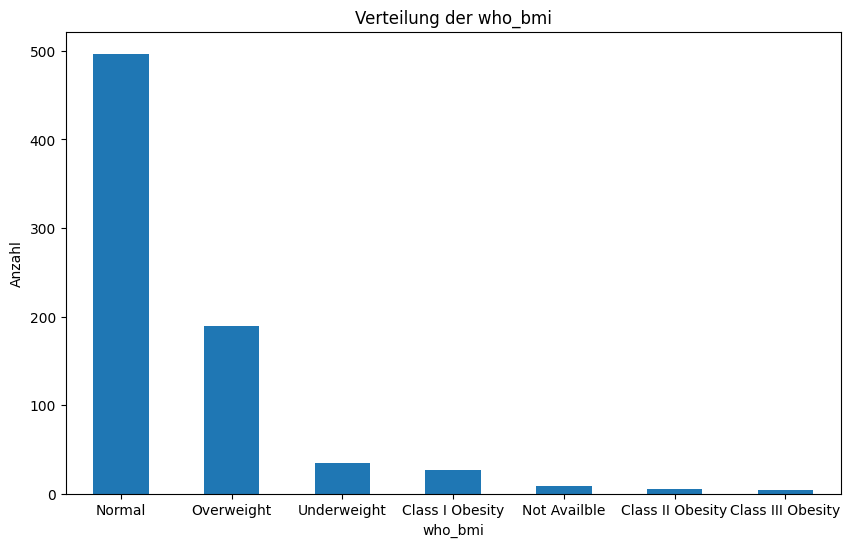

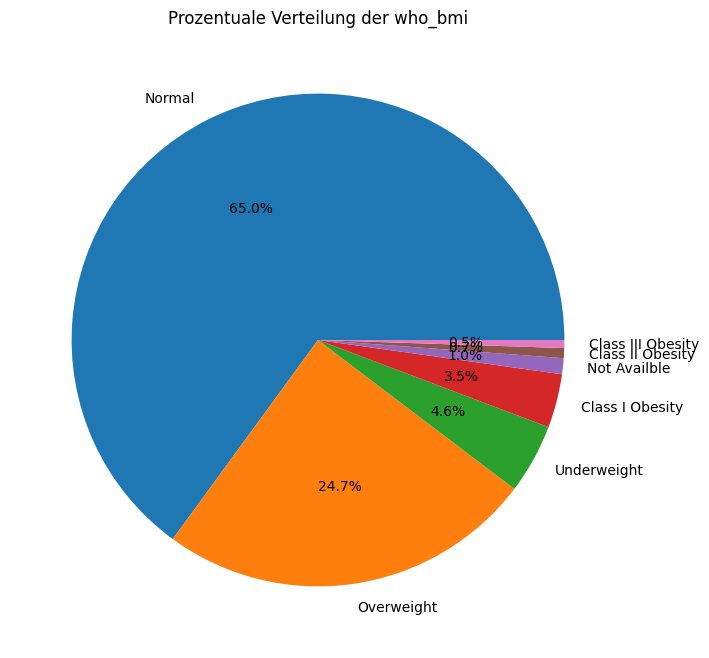

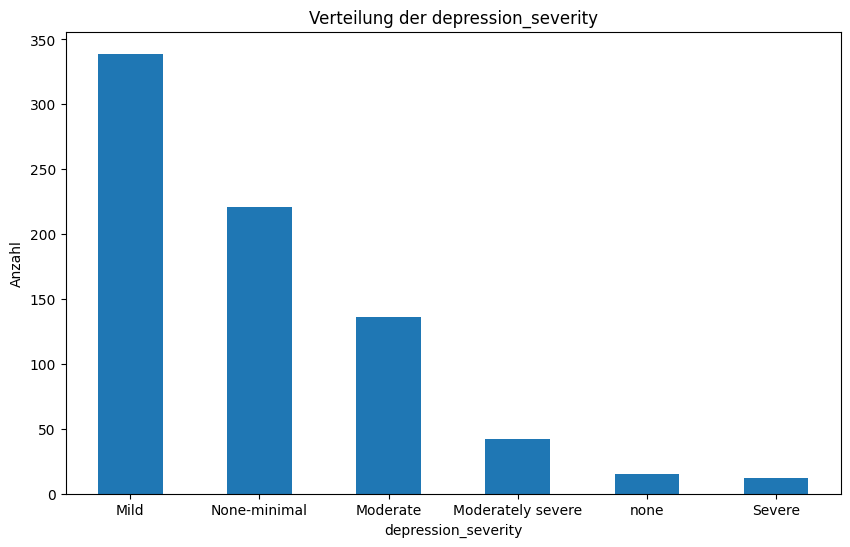

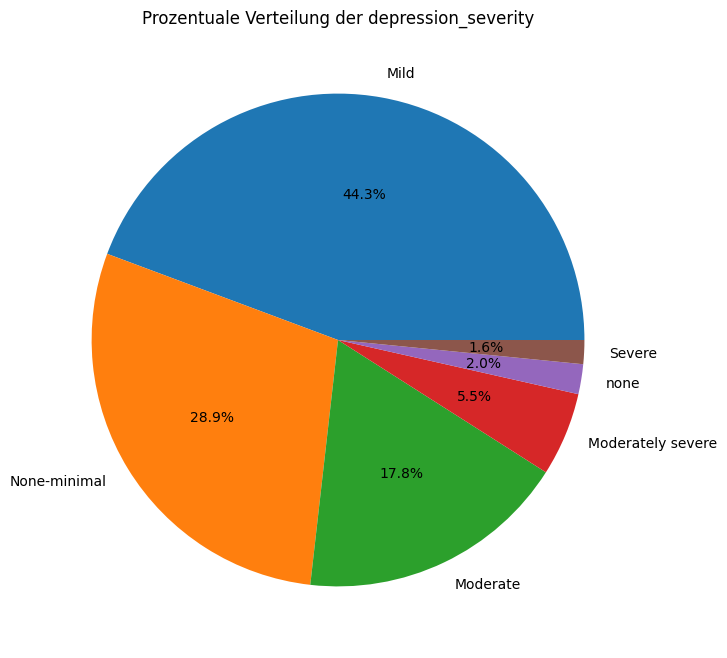

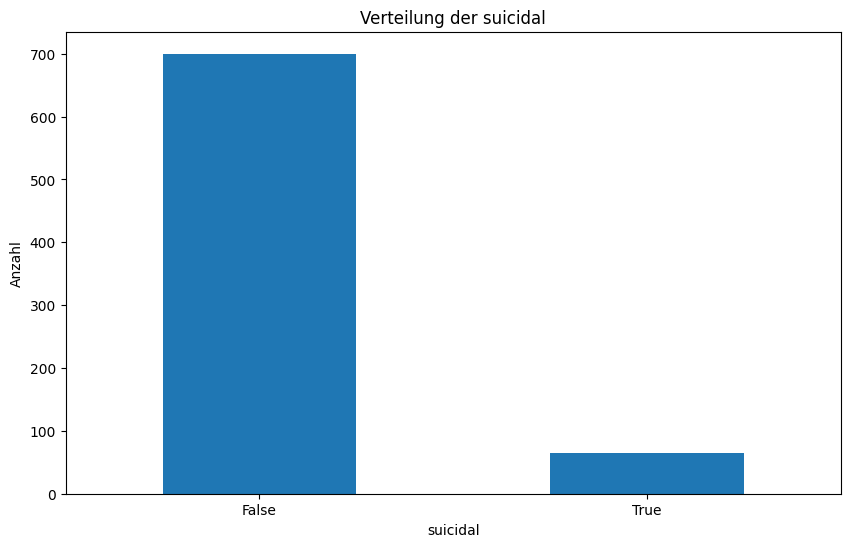

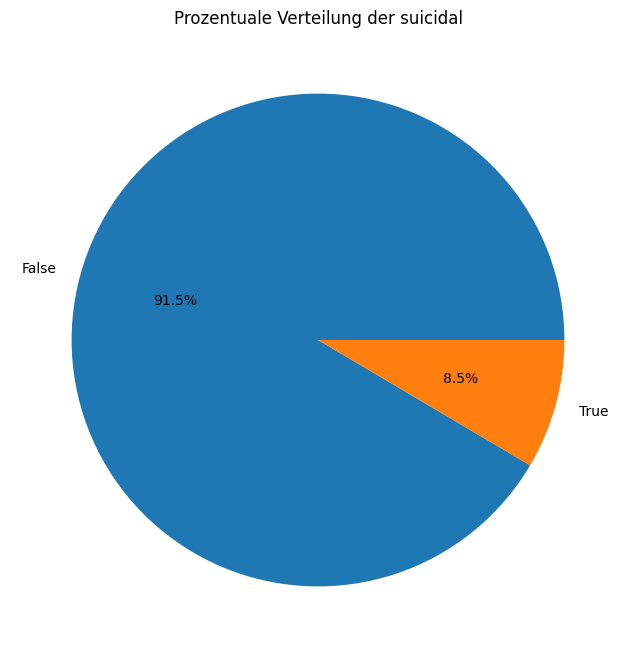

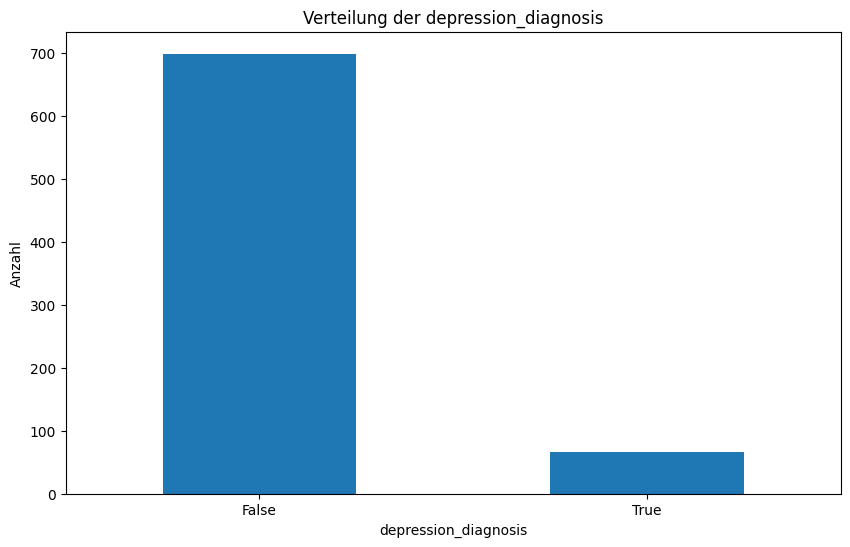

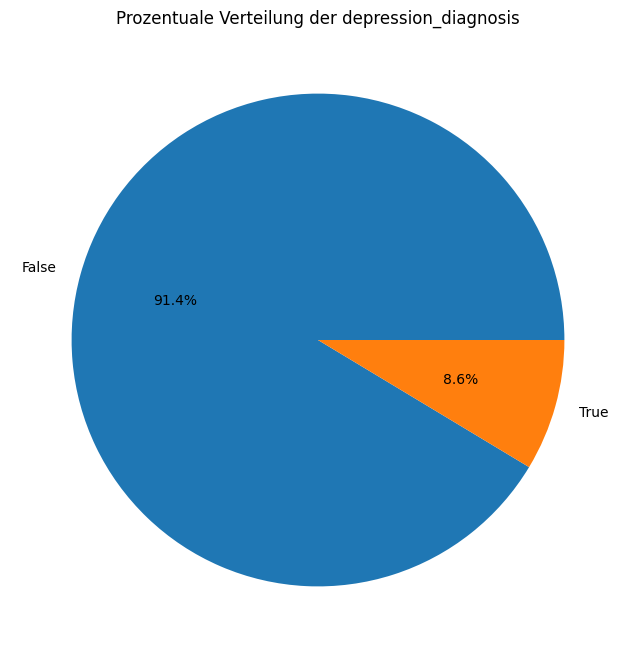

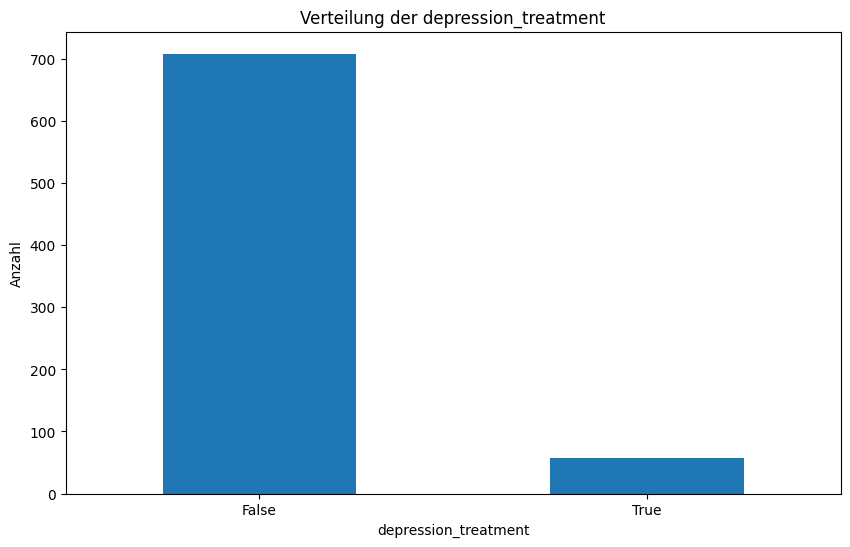

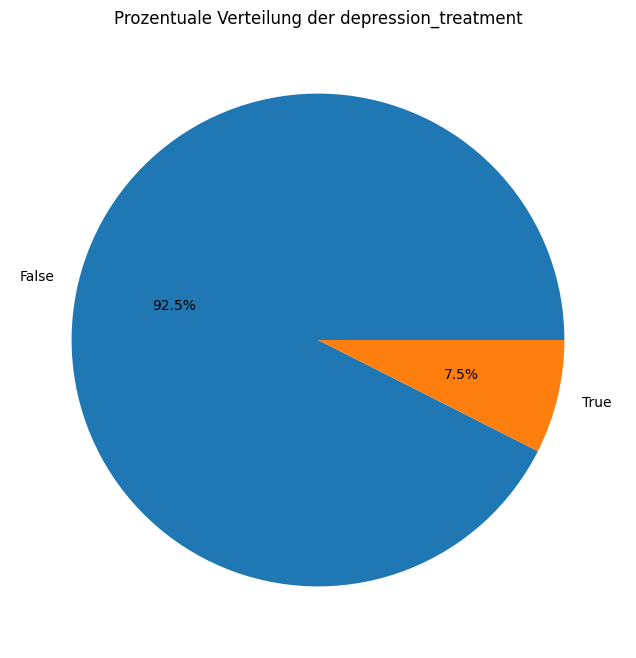

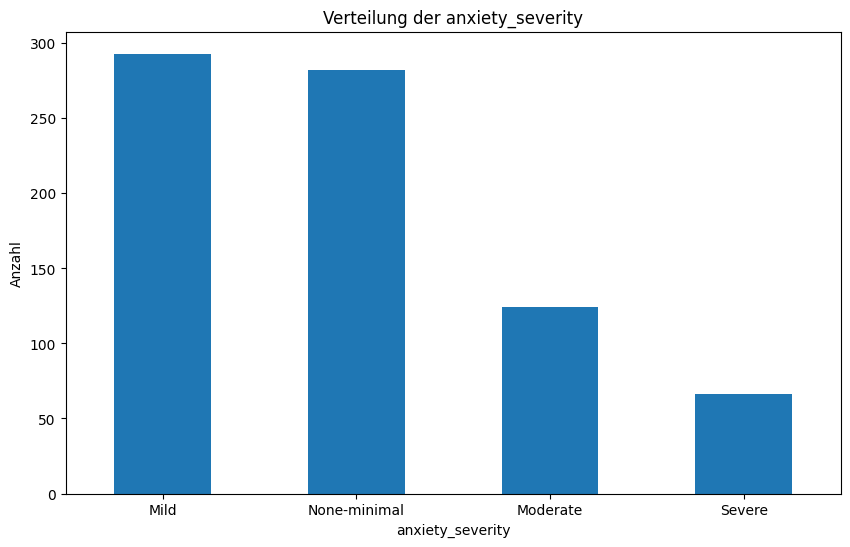

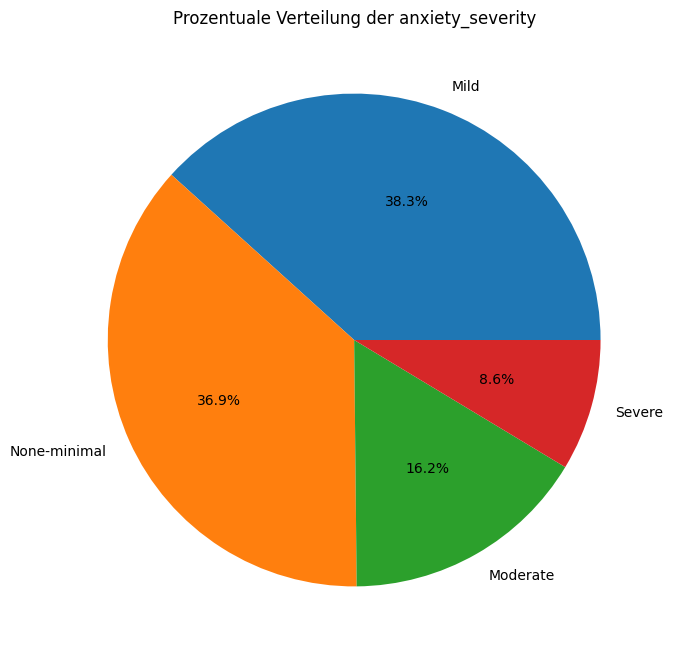

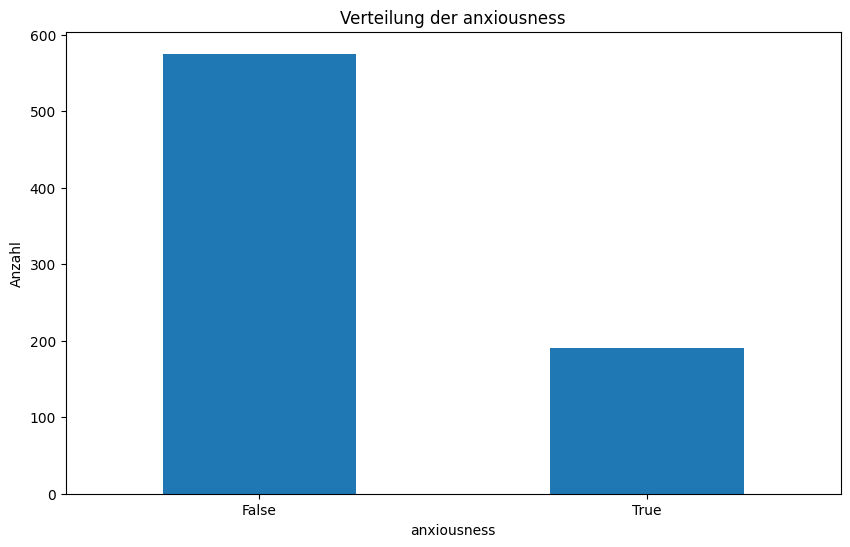

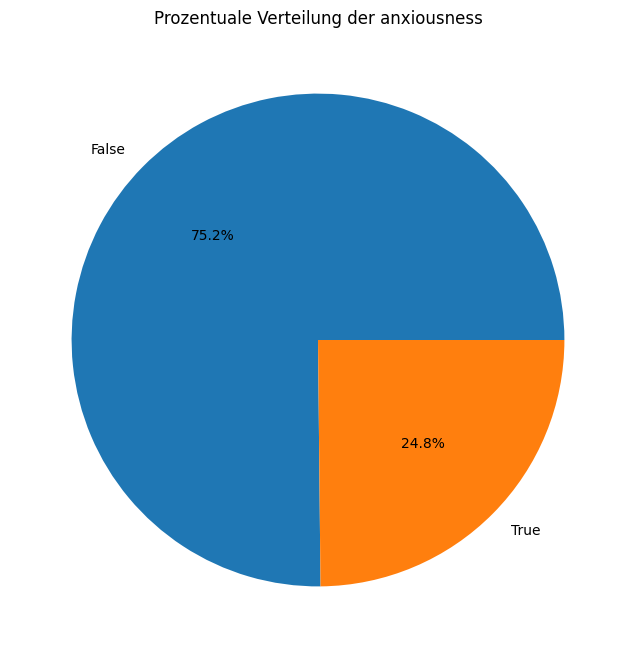

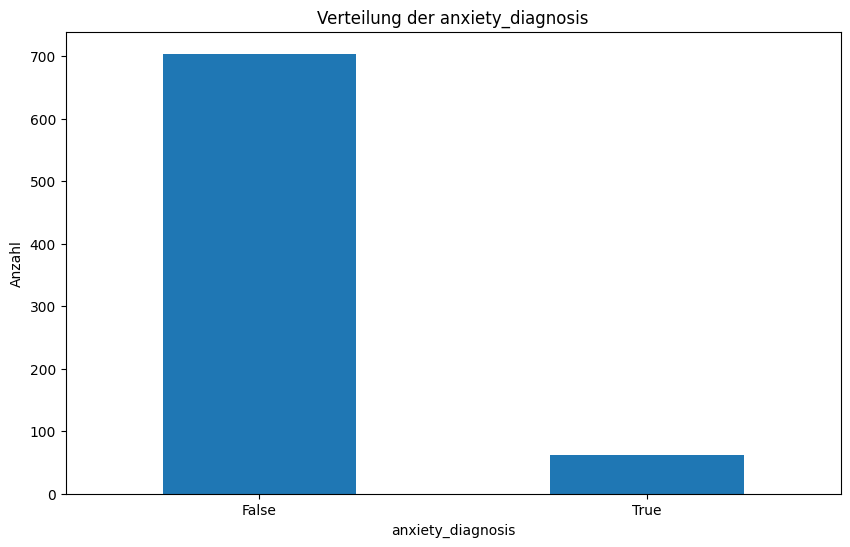

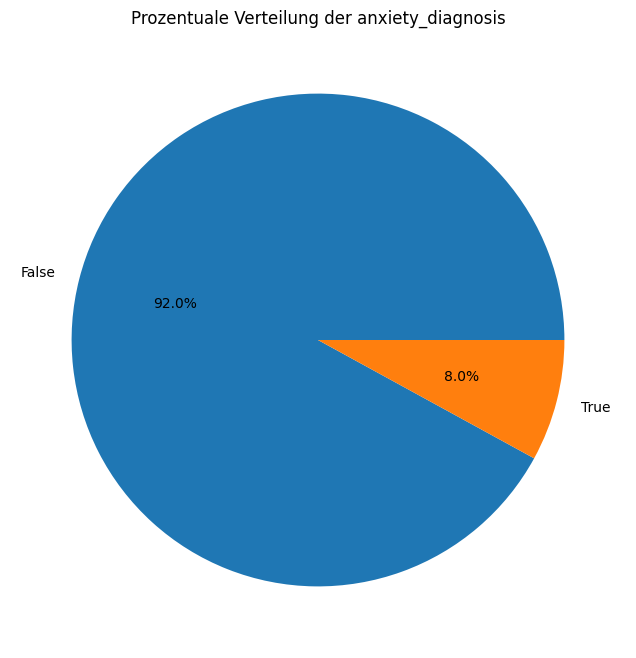

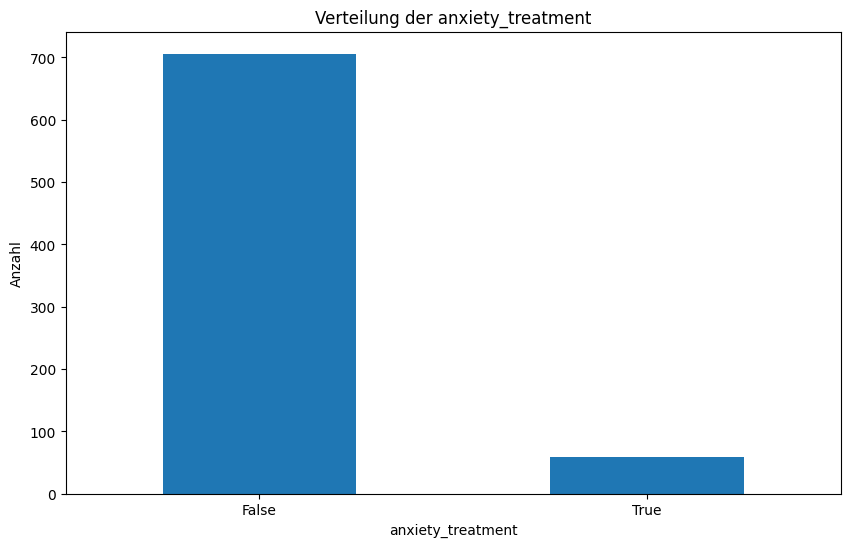

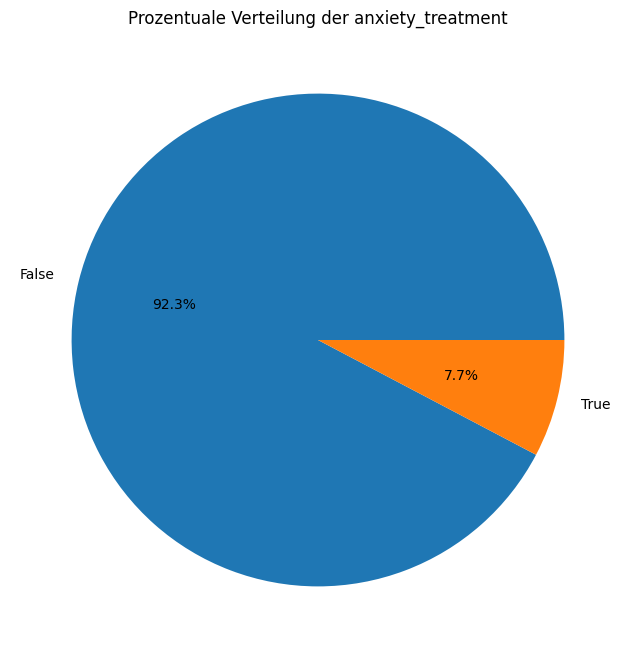

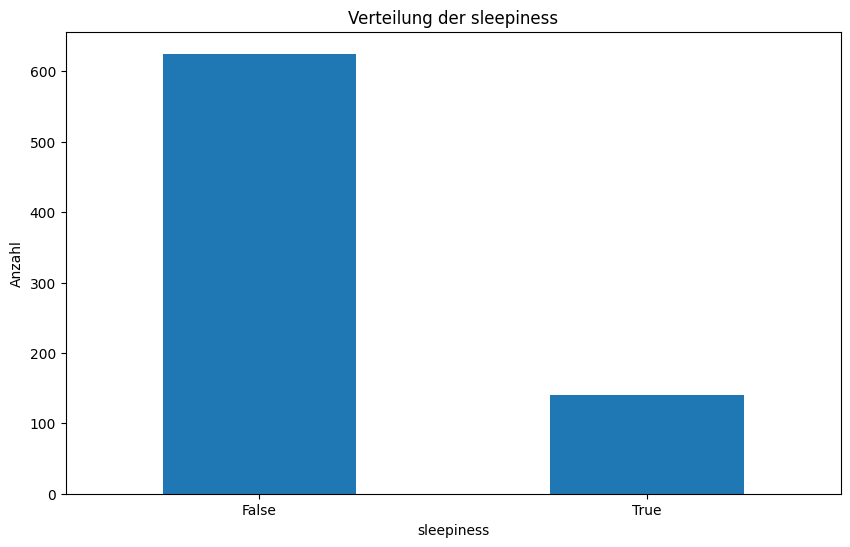

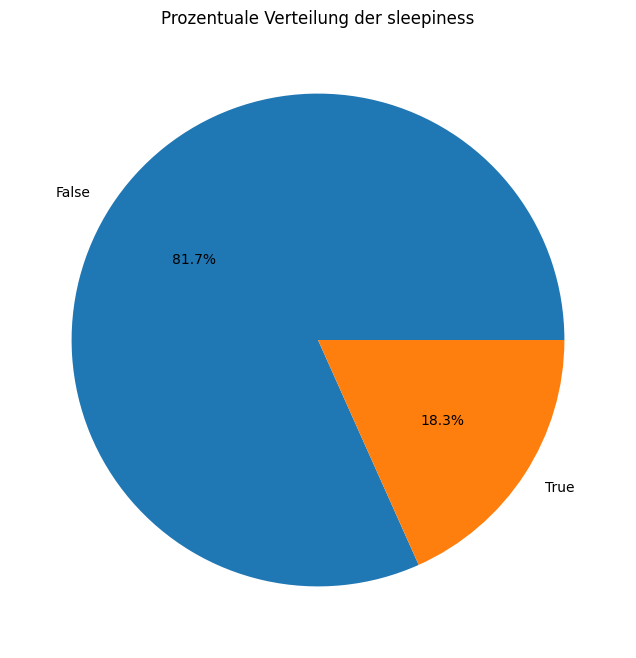

In [102]:
# Kategorien für die Plots


cat_columns = ['gender', 'who_bmi', 'depression_severity', 
                 'suicidal','depression_diagnosis', 'depression_treatment', 
                 'anxiety_severity','anxiousness', 'anxiety_diagnosis', 'anxiety_treatment', 'sleepiness']

# Bar- und Pie-Plots für jede Kategorie erstellen
for col in cat_columns:
    # Daten für den Plot vorbereiten
    counts = df[col].value_counts()

    # Barplot erstellen
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar')
    plt.title(f'Verteilung der {col}')
    plt.xlabel(col)
    plt.ylabel('Anzahl')
    plt.xticks(rotation=0)
    plt.show()

    # Pieplot erstellen
    plt.figure(figsize=(8, 8))
    counts.plot(kind='pie', autopct='%1.1f%%')
    plt.title(f'Prozentuale Verteilung der {col}')
    plt.ylabel('')
    plt.show()

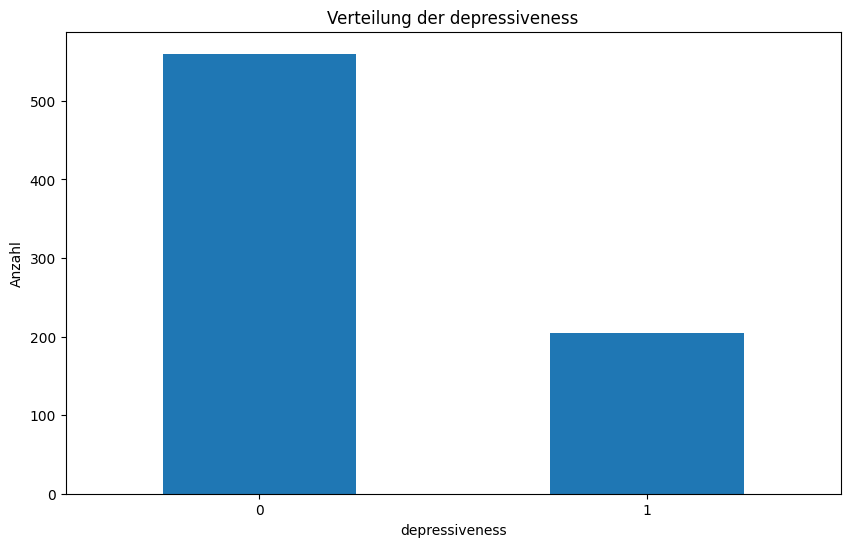

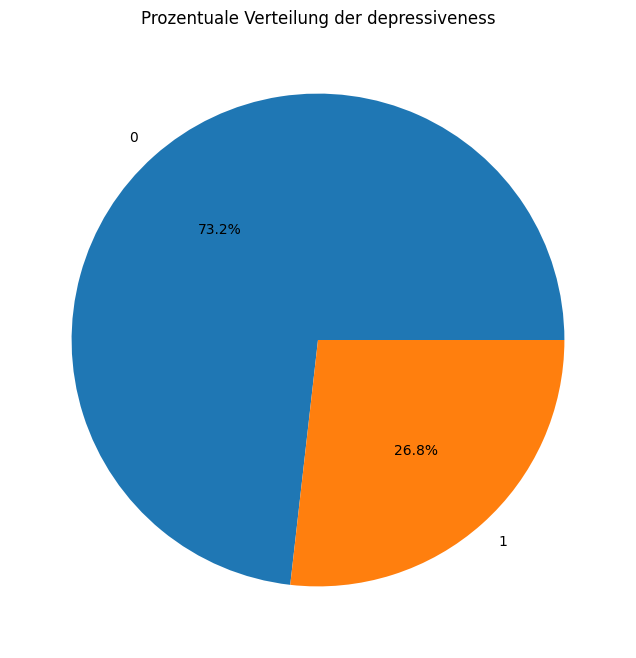

In [18]:
cat_aim = ['depressiveness']

# Bar- und Pie-Plots für jede Kategorie erstellen
for col in cat_aim:
    # Daten für den Plot vorbereiten
    counts = df[col].value_counts()

    # Barplot erstellen
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar')
    plt.title(f'Verteilung der {col}')
    plt.xlabel(col)
    plt.ylabel('Anzahl')
    plt.xticks(rotation=0)
    plt.show()

    # Pieplot erstellen
    plt.figure(figsize=(8, 8))
    counts.plot(kind='pie', autopct='%1.1f%%')
    plt.title(f'Prozentuale Verteilung der {col}')
    plt.ylabel('')
    plt.show()

In [70]:
# Erkenntnis am Montag und Dienstag habe ich eine erhöhte Anzahl von Label = 1, d.h. höher als das 
# Verhältnis label 0/Label 1 im Durchschnitt, deshalb ist die Wochentags-Spalte noch interessant und sollte aufgenommen werden,
# ev. noch ein neues Feature!

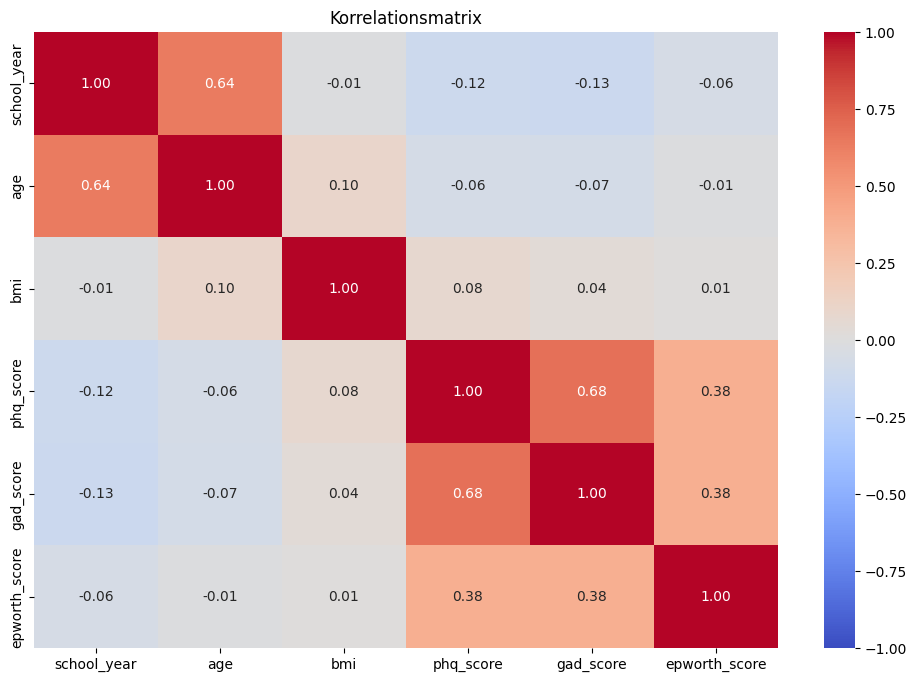

In [19]:

# Auswahl der relevanten Spalten
selected_columns = ['school_year','age','bmi', 'phq_score', 'gad_score', 'epworth_score']

# Korrelationsmatrix der ausgewählten Spalten
corr_matrix = df[selected_columns].corr()


# Heatmap der Korrelationsmatrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin = -1, vmax = 1, fmt='.2f')
plt.title('Korrelationsmatrix')
plt.show()


In [20]:
# Numerische Spalten:

# Wichtige die nicht miteinander korrelieren:

num_col = ['bmi', 'epworth_score']

num_col_pca = ['school_year', 'phq_score', 'gad_score']

cat_cols = ['gender', 'who_bmi', 'depression_severity', 
                 'suicidal','depression_diagnosis', 'depression_treatment', 
                 'anxiety_severity','anxiousness', 'anxiety_diagnosis', 'anxiety_treatment', 'sleepiness']



target = ['depressiveness']

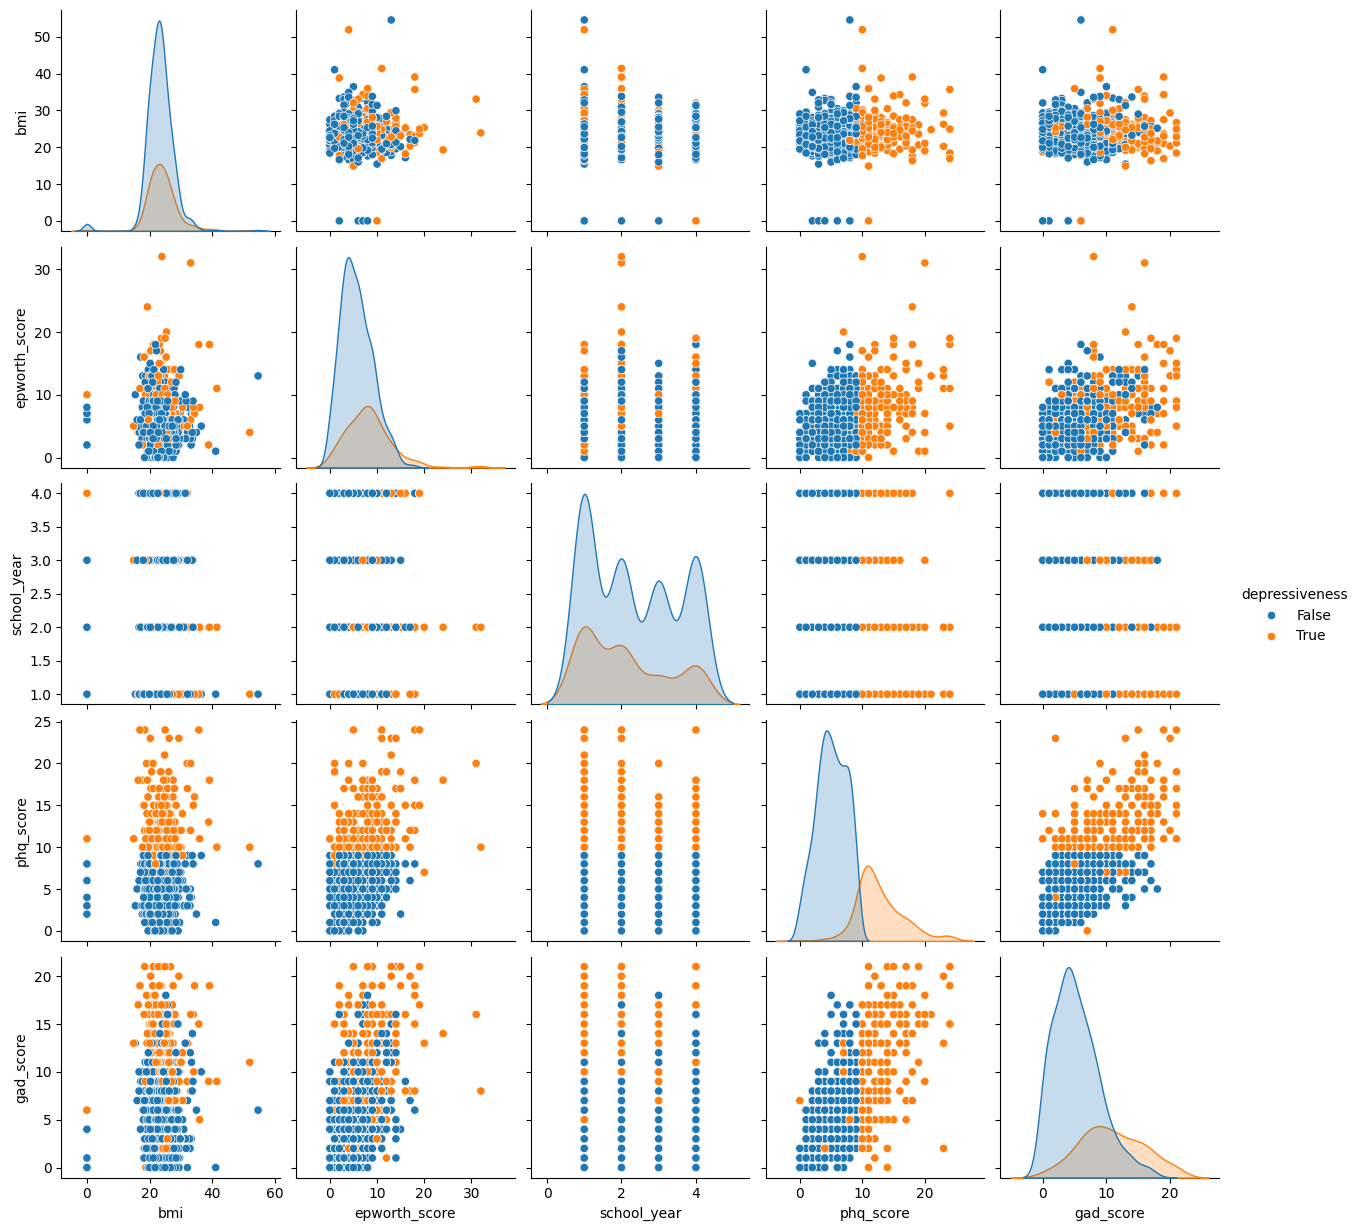

In [32]:
# Wichtigeste numerische Spalten:
#
num_cols_import = num_col + num_col_pca
# Paarweise Plot für numerische Spalten zur Untersuchung der Beziehungen
sns.pairplot(df_clean[num_cols_import + target], hue='depressiveness')
plt.show()


In [21]:
df_clean.describe()

,id,school_year,age,bmi,phq_score,gad_score,epworth_score
count,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,775.000000
mean,392.000000,2.277139,20.233716,23.420533,7.123883,6.810983,6.376774
std,226.176922,1.163633,1.767217,4.563630,4.426580,4.727352,3.996443
min,1.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000
25%,196.500000,1.000000,19.000000,20.989420,4.000000,3.000000,3.500000
50%,392.000000,2.000000,20.000000,23.140496,6.000000,6.000000,6.000000
75%,587.500000,3.000000,21.000000,25.519924,9.000000,9.000000,9.000000
max,783.000000,4.000000,31.000000,54.552668,24.000000,21.000000,32.000000


In [ ]:
# Trafo:




**Glückwunsch**:
Du hast nun einen besseren Einblick in deine Daten! Dieser kann dir beim weiteren Vorgehen weiterhelfen.

## Train-Test-Split

In diesem Projekt brauchst du sowohl die Trainings- als auch die Test- und Zieldaten. 

Die Testdaten haben wir nicht vorgegeben. Deshalb empfehlen wir dir an dieser Stelle, die Daten in ein Trainings- und Testset zu teilen und mit dem Trainingsset so zu arbeiten, als wären dies alle Daten, die du zur Verfügung hast. Wenn du dein Modell dann fertig gebaut hast, kannst du mit dem Testset simulieren, was passiert, wenn neue Daten in deine Datenpipeline hereinkommen, also beispielsweise neue Autos auf Auktionsplattformen angeboten werden.

Denke immer daran: **Always fit on Train Set only!** Das gilt inbesondere auch für die Datenbereinigung und das *Feature Engineering*. Im Idealfal fasst du dein Testset nur einmal an, und zwar, wenn du ein für dich optimales Modell gebaut und evaluiert hast und wissen möchtest, wie gut es auf ungesehenen Daten performt. Stell dir einfach vor, du hättest das Testset gar nicht vorliegen.

Nutze `train_test_split` aus dem Submodul `sklearn.model_selection`, um die Daten in Test- und Trainingsset aufzuteilen. Übergebe die folgenden Parameter: `random_state=42` und `test_size=0.1`, damit du deine Vorhersagen später mit unserem Modell vergleichen kannst und eine erste Einschätzung erhältst. Speichere zusätzlich `features_test` als *features_test.csv* ab.

In [22]:
# perform train-test-split


# Feature-Matrix und Zielvektor definieren
features = df.drop(columns=['depressiveness'])
target = df['depressiveness']

# Daten aufteilen in Trainings- und Testdaten
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, test_size=0.1, random_state=42)


In [23]:
display(features_train)

,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness
433,434,2,19,female,21.707923,Normal,6,Mild,False,False,False,14,Moderate,True,True,True,3.0,False
775,776,4,22,male,26.218821,Overweight,5,Mild,False,False,False,8,Mild,False,False,False,1.0,False
274,275,1,19,male,25.535446,Overweight,6,Mild,False,False,False,0,None-minimal,False,False,False,5.0,False
736,737,4,22,female,31.603212,Class I Obesity,5,Mild,False,False,False,2,None-minimal,False,False,False,9.0,False
70,71,1,19,female,54.552668,Class III Obesity,8,Mild,False,False,False,6,Mild,False,False,False,13.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,77,1,19,female,24.221453,Normal,17,Moderately severe,False,False,False,5,Mild,False,False,False,10.0,True
111,112,1,18,male,24.489796,Normal,3,None-minimal,False,False,False,4,None-minimal,False,False,False,6.0,False
278,279,2,19,female,19.377163,Normal,9,Mild,False,False,False,9,Mild,False,False,False,1.0,False
449,450,2,19,female,28.344671,Overweight,10,Moderate,False,False,False,7,Mild,False,False,False,5.0,False


In [24]:
# save features_test as 'features_test.csv'

# Testdaten speichern
features_test.to_csv('features_test.csv', index=False)

**Glückwunsch**:
Du hast jetzt einen Trainingsdatensatz. Diesen kannst du nutzen, um neue Features zu erzeugen und um die Bausteine deines Modells zu trainieren.

## Data Preparation


Die *Data Preparation* hat das Ziel, einen Weg zu finden, die Datensätze für dein Modell zu säubern (*Data Cleaning*) und in ein für dein Modell lesbares Format zu bringen (*Datatype Transformation*). Wenn diese Schritte vollzogen sind, kannst du dich daran machen, ein Möglichst repräsentatives Trainingsset auszuwählen (*Sampling*).

### Datatype Transformation

In [34]:
# In der Datatype Transformation werden die Typen entsprechend dem Datenblatt transformiert!

In [25]:
# Datatype Transformation
# clean_data function
def clean_data(df):
    """Returns cleaned DataFrame.
    
    Transform datatypes:
        -transform 'pickup_datetime' to datetime format
    
    Args: 
        df (pd.DataFrame) : uncleaned DataFrame
        
    Returns:
        df  (pd.DataFrame) : cleaned DataFrame
    
    """
    df_clean = df.copy()

    # go on!!!
    


    return df_clean


### Data Imputation

Im Gegensatz zum letzten Projekt gibt es in den Daten relativ viele fehlende Werte. Dies trifft auch auf die Test- und Zieldaten zu. Bei den Test- und Zieldaten solltest du **jeden** Datenpunkt klassifizieren. Aus ihnen solltest du also keinen Datenpunkt aufgrund fehlender oder unwahrscheinlicher Werte entfernen. Stattdessen könntest du die fehlenden Werte ersetzen oder Features mit vielen fehlenden Werten entfernen.

**Tipp**: Du kannst nicht davon ausgehen, dass fehlende Werte in *features_aim.csv* in den gleichen Spalten wie in *data_train.csv* vorkommen. Du brauchst also Strategien für jede Spalte. Um die fehlenden Werte mehrerer Spalten gleichzeitig mit verschiedenen Werten zu füllen, kannst du der Methode `my_df.fillna()` ein `dict` überreichen, dessen *keys* die entsprechenden Spaltennamen sind. Die *values* sind die zugehörigen Werte.

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer


print('Columns with NaN')
print('is NaN', df.isna().sum())

# Wir übernehmen den KNN Imputer:



# Erstellen des numerischen Transformations-Pipeline
""" num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('std_scaler', StandardScaler())
])

# Fit und Transform der Trainingsdaten
features_train_transformed = num_transformer.fit_transform(features_train)

# Nur Transform der Testdaten
features_test_transformed = num_transformer.transform(features_test)

# Ergebnisse anzeigen
print("Transformierte Trainingsdaten:\n", features_train_transformed)
print("Transformierte Testdaten:\n", features_test_transformed) """



Columns with NaN
is NaN id                      0
school_year             0
age                     0
gender                  0
bmi                     0
who_bmi                 0
phq_score               0
depression_severity     0
depressiveness          0
suicidal                0
depression_diagnosis    0
depression_treatment    0
gad_score               0
anxiety_severity        0
anxiousness             0
anxiety_diagnosis       0
anxiety_treatment       0
epworth_score           0
sleepiness              0
dtype: int64


' num_transformer = Pipeline(steps=[\n    (\'imputer\', KNNImputer(n_neighbors=5)),\n    (\'std_scaler\', StandardScaler())\n])\n\n# Fit und Transform der Trainingsdaten\nfeatures_train_transformed = num_transformer.fit_transform(features_train)\n\n# Nur Transform der Testdaten\nfeatures_test_transformed = num_transformer.transform(features_test)\n\n# Ergebnisse anzeigen\nprint("Transformierte Trainingsdaten:\n", features_train_transformed)\nprint("Transformierte Testdaten:\n", features_test_transformed) '

In [37]:
#display(features_train)
#display(df)

#display(target_train)

In [27]:
# Die fehlenden Werte werde ich in der Pipeline mit einem Imputer ersetzen

from sklearn.impute import SimpleImputer


num_cols_full = ['bmi', 'epworth_score', 'school_year', 'phq_score', 'gad_score']

cat_cols_missing = ['depression_severity', 'anxiety_treatment', 'sleepiness']



cat_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", OneHotEncoder(handle_unknown='ignore')),
])




#num_pipe = Pipeline(steps=[
#    ("imp", SimpleImputer(strategy="mean")),
#])

num_pipe = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('std_scaler', StandardScaler())
])




# Warnung vermeiden durch Kopieren des DataFrames, sher wichtig sonst funktioniert es nicht!
features_train = features_train.copy()
target_train = target_train.copy()


# Spalten-Transformator
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols_full),
        ('cat', cat_pipe, cat_cols_missing)
    ])

# Erstellen einer kompletten Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fitte die Pipeline auf die Trainingsdaten
features_train_transformed = pipeline.fit_transform(features_train)

# Transformiere die Testdaten
features_test_transformed = pipeline.transform(features_test)

# Ergebnisse anzeigen
print("Transformierte Trainingsdaten:\n", features_train_transformed)
print("Transformierte Testdaten:\n", features_test_transformed)


# Überprüfen auf NaN-Werte
print('Anzahl der NaN-Werte in den transformierten Trainingsdaten:', np.isnan(features_train_transformed).sum())
print('Anzahl der NaN-Werte in den transformierten Testdaten:', np.isnan(features_test_transformed).sum())

Transformierte Trainingsdaten:
 [[-0.34276404 -0.84443861 -0.24340916 ...  1.          1.
   0.        ]
 [ 0.62629405 -1.33972741  1.4830393  ...  0.          1.
   0.        ]
 [ 0.47948745 -0.34914981 -1.10663339 ...  0.          1.
   0.        ]
 ...
 [-0.84347207 -1.33972741 -0.24340916 ...  0.          1.
   0.        ]
 [ 1.082982   -0.34914981 -0.24340916 ...  0.          1.
   0.        ]
 [ 0.07901036  0.14613899 -1.10663339 ...  0.          1.
   0.        ]]
Transformierte Testdaten:
 [[-0.21931025 -0.10150541 -0.24340916 ...  0.          1.
   0.        ]
 [ 0.29815531 -0.10150541 -1.10663339 ...  1.          1.
   0.        ]
 [ 0.95959484 -0.34914981  1.4830393  ...  0.          1.
   0.        ]
 ...
 [ 0.76870212  0.88907219 -0.24340916 ...  0.          0.
   1.        ]
 [-0.01281745 -0.59679421 -1.10663339 ...  0.          1.
   0.        ]
 [ 0.6457595  -0.10150541  1.4830393  ...  0.          1.
   0.        ]]
Anzahl der NaN-Werte in den transformierten Trainings

### Deal with outliers

In [28]:
# Überprüfen der Verteilung der Zielvariablen
print(target_train.value_counts())

# Optional: Prozentuale Verteilung anzeigen
print(target_train.value_counts(normalize=True))

depressiveness
0    502
1    186
Name: count, dtype: int64
depressiveness
0    0.729651
1    0.270349
Name: proportion, dtype: float64


* Gibt es Ausreißer im Trainingsset ? - Wie sollte man mit ihnen umgehen?

In [72]:
# Man muss die Ausreißer ansehen und falls es Sinn macht, wie hier kann man sie im Set lassen.
# Ich habe über die Plots gesehen, dass es nur sehr wenige Ausreißer gibt und dass ich diese so lassen kann.
# Bei VehAge gibt es 2 Ausreißer mit 0 Jahren, die aber das Ergebnis nicht beeinflussen, habe ich 
# Model Notebook nochmals näher beschrieben

**Achtung:** Wenn du dich dazu entschließt, Ausreißer zu löschen, dann setze dies nur im Trainingset um und füge diesen Schritt **nicht** deiner Pipeline oder Cleaning-Funktion hinzu. Andernfalls wirst du bei Projektabschluss womöglich nicht für jeden Wert in *features_aim* eine Vorhersage erhalten können.

Um deine Bereinigungsschritte leicht mit den Test- und Zieldaten zu reproduzieren, solltest du eine Funktion definieren, welche die jeweiligen Schritte für dich ausführt. Nenne deine Funktion `clean_data`. Sie sollte den unbereinigten `pandas.DataFrame` als Argument erhalten und den gereinigten `pandas.DataFrame` ausgeben. Achte dabei darauf, dass keine Datenpunkte gelöscht werden, denn im Zieldatenset solltest du für jeden Wert eine Vorhersage machen.

In [114]:
from scipy.stats import pearsonr
from sklearn.cluster import DBSCAN


def identify_outliers_dbscan(X_train, correlation_threshold, num_cols, eps=0.5, min_samples=5, outlier_percentage=0.1):
    outlier_mask = pd.Series([False] * X_train.shape[0], index=X_train.index)
    columns = num_cols
    all_outlier_indices = []
    
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col_x = columns[i]
            col_y = columns[j]
            
            # Berechnen des Korrelationskoeffizienten
            correlation, _ = pearsonr(X_train[col_x], X_train[col_y])
            
            # Anwenden von DBSCAN nur bei hoher Korrelation
            if abs(correlation) >= correlation_threshold:
                X = X_train[[col_x, col_y]].values
                
                # DBSCAN anwenden
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                dbscan.fit(X)
                labels = dbscan.labels_
                
                # Ausreißer sind die Punkte mit dem Label -1
                outliers = labels == -1
                all_outlier_indices.extend(X_train.index[outliers])
    
    # Begrenzen der Anzahl der Ausreißer auf den gewünschten Prozentsatz
    all_outlier_indices = np.unique(all_outlier_indices)
    num_outliers = int(len(X_train) * outlier_percentage)
    
    if len(all_outlier_indices) > num_outliers:
        np.random.seed(0)  # Für Wiederholbarkeit
        selected_outliers = np.random.choice(all_outlier_indices, num_outliers, replace=False)
    else:
        selected_outliers = all_outlier_indices
    
    outlier_mask.loc[selected_outliers] = True
    
    return outlier_mask


# important Columns:

num_cols_import = ['bmi', 'epworth_score', 'school_year', 'phq_score', 'gad_score']

# Anwenden von identify_outliers_dbscan und Begrenzen auf 10% der Top Outliers
outlier_mask = identify_outliers_dbscan(features_train, correlation_threshold=0.7, 
                                        num_cols=num_cols_import, eps=0.7, min_samples=3, outlier_percentage=0.1)



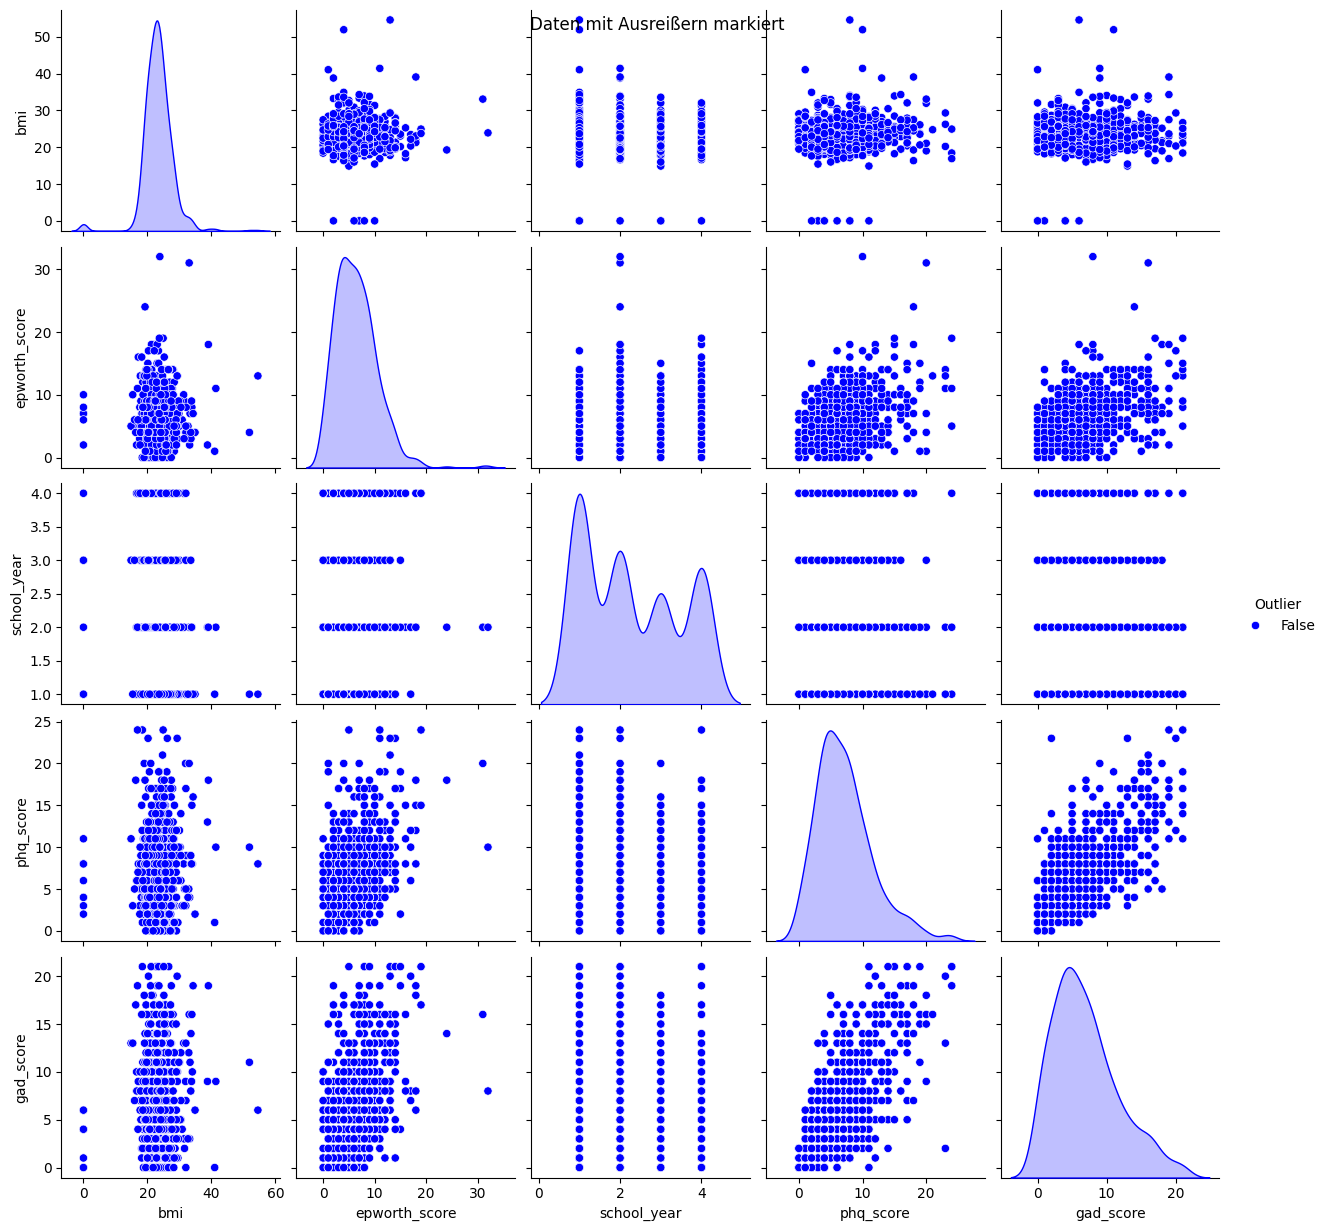

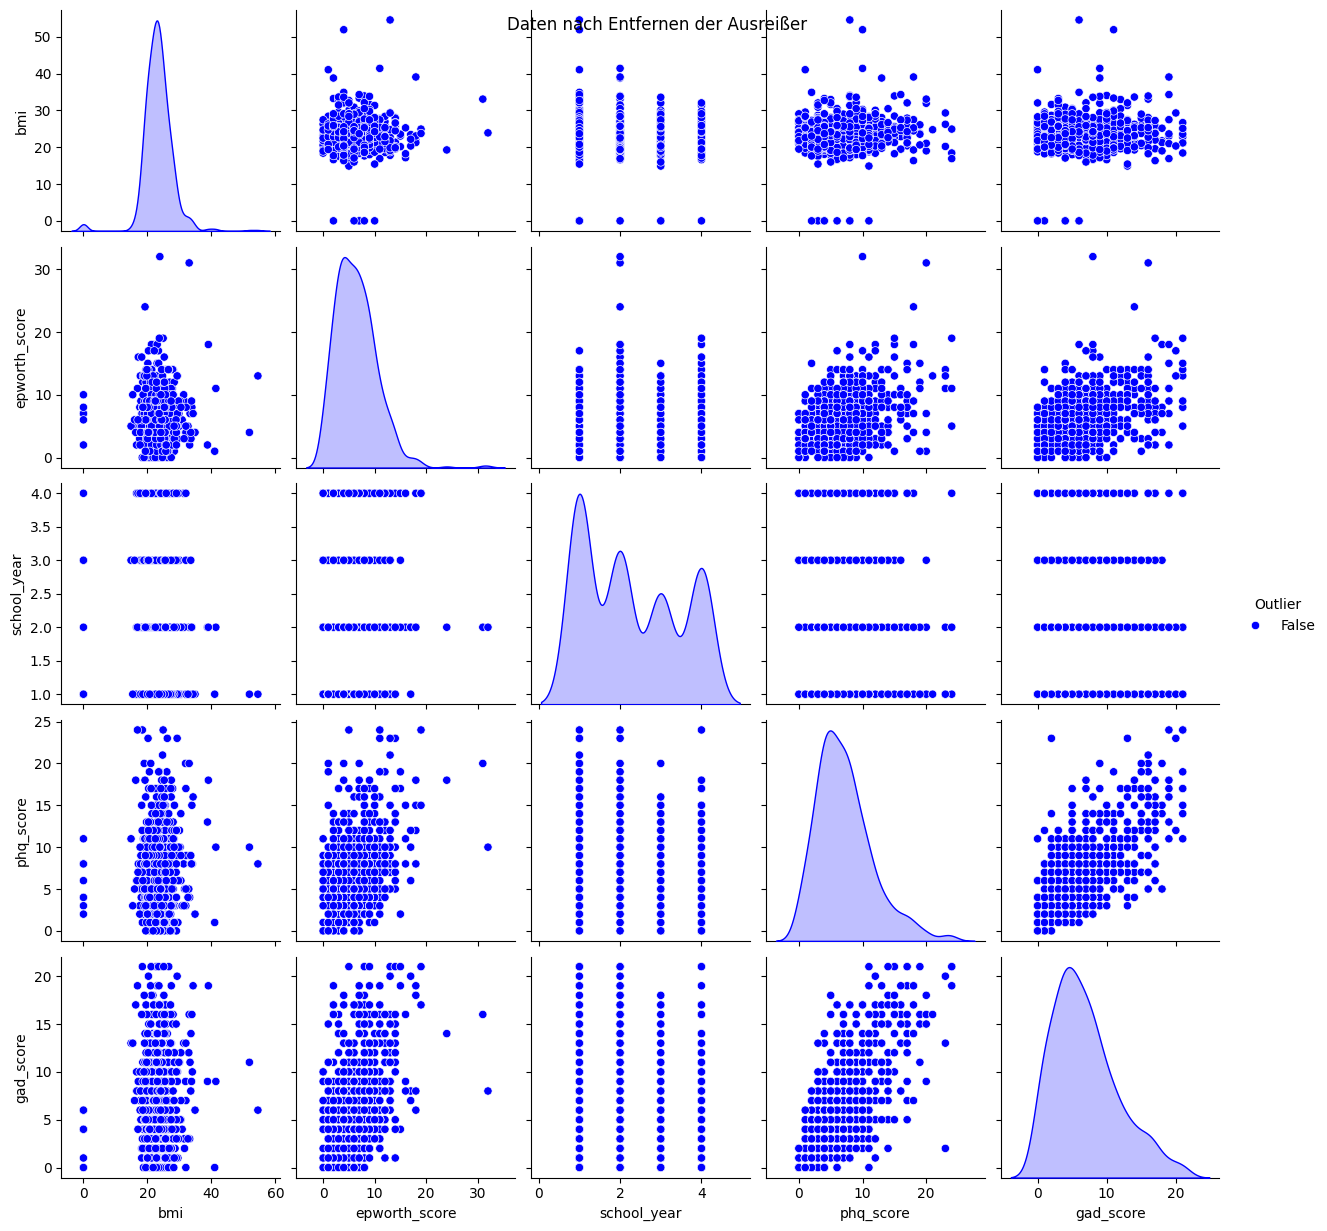

In [115]:
num_cols_print = ['bmi', 'epworth_score', 'school_year', 'phq_score', 'gad_score']





# Plot der Daten mit Ausreißern als Hue
def plot_data_with_outliers(X_train, outlier_mask, title):
    X_train_copy = X_train.copy()
    X_train_copy['Outlier'] = outlier_mask
    sns.pairplot(X_train_copy, hue='Outlier', vars=num_cols_print, diag_kind='kde', palette={True: "red", False: "blue"})
    plt.suptitle(title)
    plt.show()

plot_data_with_outliers(features_train, outlier_mask, "Daten mit Ausreißern markiert")

# Entfernen der Ausreißer
features_train_no_outliers = features_train[~outlier_mask]

# Um sicherzustellen, dass keine Spalten mit 0 Varianz vorhanden sind, können Sie diese vor dem Plotten überprüfen
def plot_data_no_outliers(X_train, num_cols_print, title):
    for col in num_cols:
        if X_train[col].nunique() <= 1:
            print(f"Skipping {col} as it has 0 variance")
            continue
        plt.figure(figsize=(10, 6))
        sns.histplot(data=X_train, x=col, hue='depressiveness', kde=True, multiple="stack")
        plt.title(f'Histogram of {col} by depressiveness')
        plt.show()

plot_data_with_outliers(features_train_no_outliers, outlier_mask[~outlier_mask], "Daten nach Entfernen der Ausreißer")

In [116]:
# Es gibt so keine kritischen Ausreisser, die ich entfernen müsste
# Anzahl der Ausreißer zählen
num_outliers = outlier_mask.sum()
print(f"Anzahl der Ausreißer: {num_outliers}")


Anzahl der Ausreißer: 0


### Resample

Wie du sicherlich festgestellt hast, sind die Zielkategorien im Datensatz sehr unausgeglichen. Es kann also notwendig sein, dein Trainingsdatenset zu resamplen. In *Unausgeglichene Zeilkategorien* (Modul 2, Kapitel 3) hast du verschiedene Methoden des *resampling* kennengelernt und auch gelernt, wie man `imblearn.pipeline` nutzt, um verschiedene Samplingmethoden zu testen.

In [29]:
# Ich werde einen Oversampler verwenden und am Anfang einmal sampeln.
# Später auf der 

from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

# Hier arbeite ich einen Oversampler ein!
#rf_pipe = ImbPipeline(steps=[
#    ("pre", preprocessing),
#    ("oversampler", RandomOverSampler()),   # Hinzufügen des RandomOverSamplers
#    ("kbest", SelectKBest(k=10, score_func=f_classif)),
#    ("model", RandomForestClassifier()),
#])


In [118]:
# Überprüfen der Verteilung der Zielvariablen
print(target_train.value_counts())

# Optional: Prozentuale Verteilung anzeigen
print(target_train.value_counts(normalize=True))





depressiveness
False    502
True     186
Name: count, dtype: int64
depressiveness
False    0.729651
True     0.270349
Name: proportion, dtype: float64


In [119]:




import pickle
# Daten und Modelle in einem Dictionary speichern:
state = {
    'features_train': features_train,
    'target_train': target_train,
    'features_test': features_test,
    'target_test': target_test,    
#    'rf_pipe': rf_pipe
}
# Dictionary speichern:
with open('state.pkl', 'wb') as f:
    pickle.dump(state, f)


In [27]:

# Zustand wieder laden:
import pickle

with open('state.pkl', 'rb') as f:
    state = pickle.load(f)

features_train = state['features_train']
target_train = state['target_train']

features_test = state['features_test']
target_test = state['target_test']


#rf_pipe = state['rf_pipe']

In [30]:
display(features_train)

display(features_train.dtypes)

,id,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness
433,434,2,19,female,21.707923,Normal,6,Mild,False,False,False,14,Moderate,True,True,True,3.0,False
775,776,4,22,male,26.218821,Overweight,5,Mild,False,False,False,8,Mild,False,False,False,1.0,False
274,275,1,19,male,25.535446,Overweight,6,Mild,False,False,False,0,None-minimal,False,False,False,5.0,False
736,737,4,22,female,31.603212,Class I Obesity,5,Mild,False,False,False,2,None-minimal,False,False,False,9.0,False
70,71,1,19,female,54.552668,Class III Obesity,8,Mild,False,False,False,6,Mild,False,False,False,13.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,77,1,19,female,24.221453,Normal,17,Moderately severe,False,False,False,5,Mild,False,False,False,10.0,True
111,112,1,18,male,24.489796,Normal,3,None-minimal,False,False,False,4,None-minimal,False,False,False,6.0,False
278,279,2,19,female,19.377163,Normal,9,Mild,False,False,False,9,Mild,False,False,False,1.0,False
449,450,2,19,female,28.344671,Overweight,10,Moderate,False,False,False,7,Mild,False,False,False,5.0,False


id                        int64
school_year               int64
age                       int64
gender                   object
bmi                     float64
who_bmi                  object
phq_score                 int64
depression_severity      object
suicidal                 object
depression_diagnosis     object
depression_treatment     object
gad_score                 int64
anxiety_severity         object
anxiousness              object
anxiety_diagnosis        object
anxiety_treatment        object
epworth_score           float64
sleepiness               object
dtype: object

## Modeling

Kommen wir nun zur Kernaufgabe eines *Data Scientist*, dem Bauen von Maschine-Learning-Modellen. Wie du es im Training bereits gelernt hast, ist das Optimieren eines Modells ein iterativer Prozess. Die nachfolgenden Schritte wirst du also sicher mehr als einmal durchführen.

### Build a simple Baselinemodel

Bevor du dich nun der Erzeugung und Auswahl neuer Features widmest, solltest du erst einmal sehen, von welchem Punkt du deine Bemühungen startest und ein erstes einfaches Modell ohne jegliche Hyperparameteroptimierung erzeugen. So kannst du hinterher immer wieder überprüfen, ob die folgenden Schritte in der Modelloptimierung eine Verbesserung bringen. Am besten erzeugst du eine Pipeline, die neben der Modellierung auch das Encoden nicht-numerischer Features übernimmt. Ich schlage folgendes Vorgehen vor:
1. Numerische Features (`num_cols`) und kategorische Features (`cat_cols`) definieren,
3. Algorithmus für das Baselinemodel aussuchen und als `model` instanziieren,
3. Pipeline (`model_baseline`) nach dem Schema unten erstellen,
4. Das gereinigte und ggf. gefilterte `features_train` sowie das entsprechende `target _train` zum *fitten* verwenden,
5. mit `model_baseline` Vorhersagen treffen auf das gereinigte `features_test`.

<img src="03_05_01_pic1_baselinepipe.png">

In [62]:
# define num_cols and cat_cols



num_cols =['school_year','age','bmi', 'phq_score', 'gad_score', 'epworth_score']


cat_cols_full = ['gender', 'who_bmi', 'depression_severity', 
                 'suicidal','depression_diagnosis', 'depression_treatment', 
                 'anxiety_severity','anxiousness', 'anxiety_diagnosis', 'anxiety_treatment', 'sleepiness']

cat_cols = ['gender', 'who_bmi', 'depression_severity', 
                 'suicidal','depression_diagnosis', 'depression_treatment', 
                 'anxiety_severity','anxiousness', 'anxiety_diagnosis', 'anxiety_treatment', 'sleepiness']



target = ['depressiveness']


target = ['corona_result']




# Definieren der Spaltenlisten


num_2_cols = ['school_year','age','bmi', 'phq_score', 'gad_score', 'epworth_score']

# without the psychologist columns; 'phq_score', 'gad_score',
num_2_cols = ['school_year','age','bmi', 'epworth_score']

In [79]:

# Kategorische Spalten definieren mittels EDA
cat_2_cols = ['gender', 'who_bmi', 'depression_severity', 
                 'suicidal','depression_diagnosis', 'depression_treatment', 
                 'anxiety_severity','anxiousness', 'anxiety_diagnosis', 'anxiety_treatment', 'sleepiness']

# without the psychologist columns
cat_2_cols = ['gender']

# Anzahl der Kategorien pro Spalte berechnen
for col in cat_2_cols:
    num_categories = df_clean[col].nunique()
    print(f'Anzahl der Kategorien in {col}: {num_categories}')
    


Anzahl der Kategorien in gender: 2


In [80]:
# instantiate model

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier





In [81]:
# Installation des TargetEncoder von category_encoder

!pip install category_encoders
import category_encoders as ce


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Trainee\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [82]:
# Go on!!!!
# Beispiel für numerische und kategorische Spalten
numeric_features = num_2_cols
categorical_features = cat_2_cols

# Preprocessing Pipelines für numerische und kategorische Daten
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('encoder', ce.TargetEncoder())])

# ColumnTransformer zum Kombinieren der Preprocessing-Schritte
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Erstellen der Pipeline mit Preprocessing und dem Modell
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())])

# Fit auf die Trainingsdaten
rf_pipe.fit(features_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['school_year', 'age', 'bmi',
                                                   'epworth_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder())]),
                                                  ['gender'])])),
                ('classifier', RandomForestClassifier())])

In [83]:





# Eigene Klasse mit Zeiterfassung



cat_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="constant", fill_value="missing")),
    ("target_enc", ce.TargetEncoder())  # TargetEncoder hinzufügen
#    ("ohe", OneHotEncoder(handle_unknown='ignore')),  # One-Hot encoder
])

num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="mean")),
#    ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # PolynomialFeatures hinzufügen, bringt nichts, da man
#    Lineare Kombinationen hat
    ("scaler", StandardScaler()),
])


preprocessing = ColumnTransformer(
    transformers=[
        ("num_trans", num_pipe, num_2_cols),
        ("cat_trans", cat_pipe, cat_2_cols),
    ],
    remainder = "drop",
)


# Resampling

from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler


# In meine Pipeline habe ich den RandomOverSapler eingebout 


rf_pipe = ImbPipeline(steps=[
    ("oversampler", RandomOverSampler()),   # Hinzufügen des RandomOverSamplers
    ("pre", preprocessing),
    ("kbest", SelectKBest(k=10, score_func=f_classif)),
    ("model", RandomForestClassifier()),
#    ("model", RandomForestClassifier_mod()),
])



In [84]:
display(target_train.head())

433    0
775    0
274    0
736    0
70     0
Name: depressiveness, dtype: int32

In [85]:
# fit pipeline on cleaned (and filtered) training set

rf_pipe.fit(features_train, target_train)  # Standard

# rf_pipe_mod.fit(features_train, target_train)  # Modified

C:\Users\Trainee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=5. All the features will be returned.
  warnings.warn(


Pipeline(steps=[('oversampler', RandomOverSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['school_year', 'age', 'bmi',
                                                   'epworth_score']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('target_enc',
                                                                   TargetEncoder())]),
                                                  ['gender'])])),
                ('kbest', SelectKBest()), ('model', RandomForestClassifier())])

In [86]:
# predict and evaluate on test set

print(classification_report(target_test, rf_pipe.predict(features_test)))






              precision    recall  f1-score   support

           0       0.80      0.88      0.84        58
           1       0.46      0.32      0.38        19

    accuracy                           0.74        77
   macro avg       0.63      0.60      0.61        77
weighted avg       0.71      0.74      0.72        77



In [87]:
from sklearn.model_selection import cross_val_score


# Assuming 'model' is your trained model and 'X' and 'y' are your features and target
scores = cross_val_score(rf_pipe, features_train, target_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", scores)
print("Mean Cross-Validation Accuracy:", scores.mean())

C:\Users\Trainee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=5. All the features will be returned.
  warnings.warn(
C:\Users\Trainee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=5. All the features will be returned.
  warnings.warn(
C:\Users\Trainee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=5. All the features will be returned.
  warnings.warn(
C:\Users\Trainee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p

Cross-Validation Accuracy Scores: [0.71014493 0.65217391 0.69565217 0.72992701 0.64963504]
Mean Cross-Validation Accuracy: 0.6875066116576749


In [78]:
# Prediction

print(rf_pipe.predict(features_test))

[0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1
 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1]


C:\Users\Trainee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\Trainee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(n

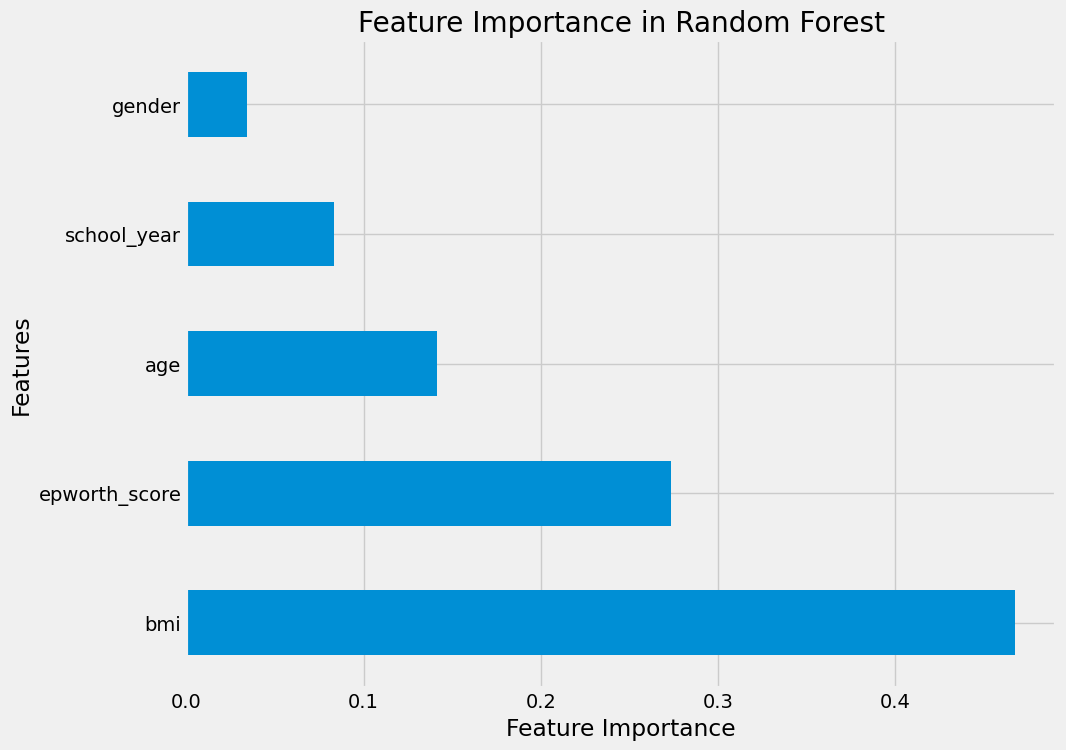

In [88]:

# Feature Importance ermitteln
rf_model = rf_pipe.named_steps['model']

# Extrahieren der Feature-Namen nach der Transformation
preprocessor = rf_pipe.named_steps['pre']
kbest = rf_pipe.named_steps['kbest']
selected_features = kbest.get_support(indices=True)

# Numerische und kategorische Feature-Namen nach der Transformation
num_feature_names = num_2_cols
cat_feature_names = cat_2_cols

# Kombinierte Liste der ursprünglichen Features
all_features = num_feature_names + cat_feature_names

# Ausgewählte Features nach SelectKBest
selected_feature_names = [all_features[i] for i in selected_features]

# Erzeuge eine Serie mit den Feature Importances
feature_importance_rf = pd.Series(rf_model.feature_importances_, index=selected_feature_names)

# Sortiere die Werte und wähle die Top 10 Features aus
top_10_features = feature_importance_rf.nlargest(10)

# Erzeuge ein Balkendiagramm
plt.style.use('fivethirtyeight')
top_10_features.plot(kind='barh', figsize=(10, 8))

# Füge Beschriftungen hinzu
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')

# Zeige das Diagramm an
plt.show()

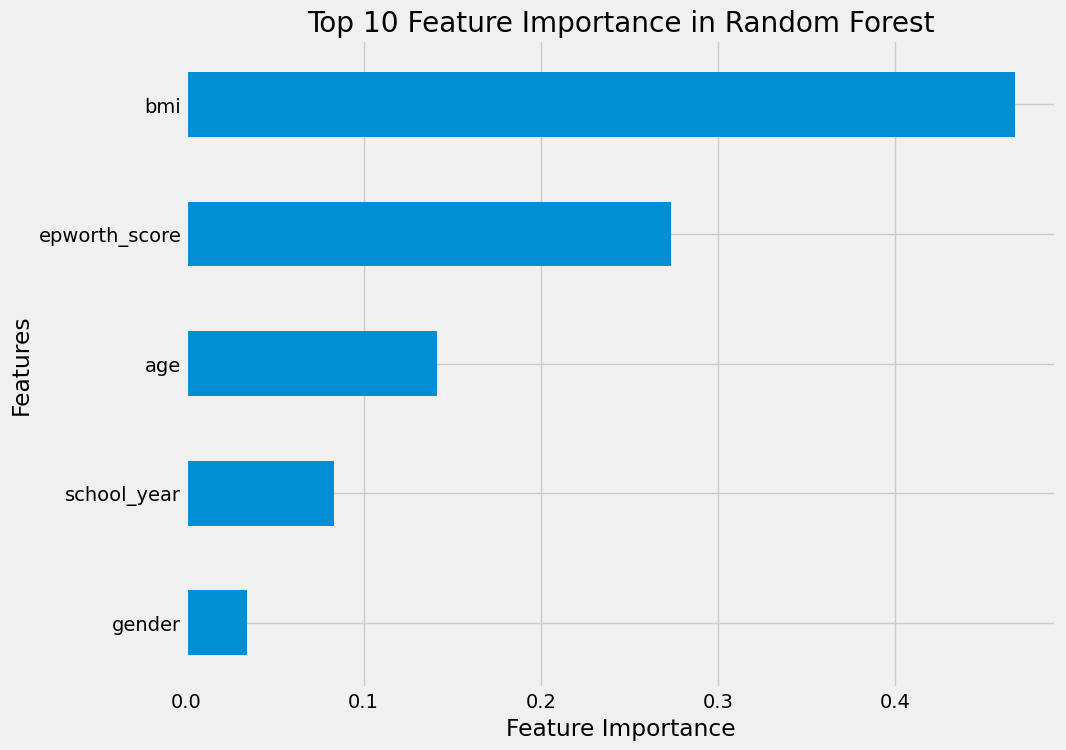

In [89]:

# Sortiere die Werte und wähle die Top 10 Features aus
top_10_features = feature_importance_rf.nlargest(10).sort_values()

# Erzeuge ein Balkendiagramm für die Top 10 Features
plt.style.use('fivethirtyeight')
top_10_features.plot(kind='barh', figsize=(10, 8))

# Füge Beschriftungen hinzu
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importance in Random Forest')

# Zeige das Diagramm an
plt.show()

In [90]:



from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier




# Fist Idea of a grid search:

# Modified GridSearch

#class GridSearchCV_mod(GridSearchCV):
#    @timeit
#    def fit(self, X, y=None, **fit_params):
#        return super().fit(X, y, **fit_params)




# Parameter Grid definieren für RF_mod
#param_grid = {
#    'model__n_estimators': [100],  # , 200],  # , 300],
#    'model__max_features': [None, 'sqrt'],  # , 'log2'],
#   'model__max_depth': [10, 20],  # , 30, None],
#    'model__min_samples_split': [2, 5],  # , 10],
#    'model__min_samples_leaf': [2, 4],  # [1, 2, 4]
#    'model__max_samples_leaf': [0.1, 0.2],  # Beispielsweise zwei Werte zur Auswahl
#}

# Parameterraum mit normalem RF
#param_grid = {
#    'model__n_estimators': [100] , # , 200],  # , 300],
#    'model__max_features': [None, 'sqrt'],  # , 'log2'],
#    'model__max_depth': [10, 20],  # , 30, None],
#    'model__min_samples_split': [2, 5],  # , 10],
#    'model__min_samples_leaf': [2, 4],  # [1, 2, 4]
#}

param_grid = {
    'model__n_estimators': [100, 200],  # , 300],
    'model__max_features': ['sqrt', 'log2'],
    'model__max_depth': [10],  # , 30, None],
    'model__min_samples_split': [2, 5],  # , 10],
    'model__min_samples_leaf': [2, 4],  # [1, 2, 4]
}

# GridSearchCV durchführen # opimise the model after precision


#grid_search_rf = GridSearchCV_mod(rf_pipe, param_grid, cv=5, scoring='f1', n_jobs=-1)  # Standard

grid_search_rf = GridSearchCV(rf_pipe, param_grid, cv=5, scoring='f1', n_jobs=-1)  # Standard

#grid_search_rf = GridSearchCV(rf_pipe_mod, param_grid, cv=5, scoring='f1', n_jobs=-1)  # modified

grid_search_rf.fit(features_train, target_train)

# Beste Parameter und Ergebnis anzeigen
print(f'Best parameters: {grid_search_rf.best_params_}')
print(f'Best score: {grid_search_rf.best_score_}')


C:\Users\Trainee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=5. All the features will be returned.
  warnings.warn(


Best parameters: {'model__max_depth': 10, 'model__max_features': 'log2', 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best score: 0.413062097107169


In [74]:
# Prediction with an aim-Dataset


#  Example aim-file


# Reading the CSV file into a DataFrame
X_aim = pd.read_csv('depression_aim.csv')

y_pred_aim = grid_search_rf.predict(X_aim)
print(X_aim)
print(y_pred_aim)

# 0 is not depressive
# 1 is depressiv

   id  school_year  age  gender        bmi          who_bmi  phq_score  \
0   1            1   19    male  33.333333  Class I Obesity          9   
1   2            1   18    male  19.841270           Normal          8   
2   3            1   19  female  25.102391       Overweight         18   

  depression_severity  depressiveness  suicidal  depression_diagnosis  \
0                Mild           False     False                 False   
1                Mild           False     False                 False   
2                Mild           False     False                 False   

   depression_treatment  gad_score anxiety_severity  anxiousness  \
0                 False         11         Moderate         True   
1                 False          5             Mild        False   
2                 False          6             Mild        False   

   anxiety_diagnosis  anxiety_treatment  epworth_score  sleepiness  
0              False              False              7       False  

C:\Users\Trainee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\Trainee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(n